# Introduction

New technological opportunities make it more and more possible to advance our medical capacities. As a logical next step, we want to automate diagnosis of a couple of different health issues. If succesful, such an ability could help medical doctors eliminate time consuming diagnosis steps, and render them capable to provide help to their patients quickly. 

In this project, we will be working towards building a health issues prediction system. A user will be able to access this system through an interface, where they will be able to enter required data and get a quick prediction about the health condition in question. 

The first model we want to build is about predicting stroke risks in patients. A stroke is a condition about the blood flow to the brain. This is a very serious and life-threatining condition. Predicting such a condition before it happens would be able to help doctors to give their patients treatment before the condition occurs. We want to be able to identify as many people with a stroke risk as possible. Our aim is to not miss anyone with a risk. In order to measure the success, we will use the metric called recall.

The next model is about hypertension prediction. Hypertension is the condition where a patient's blood pressure is higher than normal. This is not as life-threatining as a stroke. Nevertheless, this could be very dangerous for an individual if go undetected. Our aim for this model is to predict the hypertension risk of a patient, before they actually get tested. If sucessful this model could help patients to get the necessary treatment. It can also reduce the costs of the medical instituion by eliminating tests to detect the problem. As before, we will use recall to understand our success in predicting this label.

Later, we will move on to predict several other important health aspects. Glucose is the main energy supply of human body. As with all things, this is only health in normal levels. Irregular levels may lead to several health conditions. Glucose is measured by blood tests. With this model, we will try to eliminate blood tests by predicting glucose levels for each patient. Root mean squared error will be used to see how much different an average prediction is from real value. This metric is very useful, as it is in the same scale with our data. 

Lastly, we want to predict a patient's BMI. This is a measure of the combination of height and weight. A very high or very low BMI could risk a patient's health in long term. This value is measured by taking a patient's height and weight. The model aims to eliminate this step from the diagnosis, so that patients can be diagnosed quicker. For the same reasons as the previous model, we will be using root mean squared error to measure our success in this model.  

We will be also building a combination some of these models, so that the user can easily predict more than one measure of interest without providing information several times. 

# Methodology

In this project, we have used visualizations to gain insight from our data. Several statistical inference methods were applied to be confident in our analysis. In order to predict targets, we used several machine learning algorithms. These algorithms rank from simple to more complex, and each were tested to make sure the suitable algorithm is found. After the machine learning steps, the models were deployed with an API and served on a user interface to be easily accessed.

# Data Preparation

In [1005]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import association_metrics as am
import statsmodels
import shap
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as SMOTEPipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    ElasticNet,
    SGDRegressor,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    log_loss,
    ConfusionMatrixDisplay,
    mean_squared_error,
    r2_score,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.utils import class_weight
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from helper.modeltools import (
    make_preprocessor,
    cross_validate_model,
    shap_feat_reduce_classification,
    shap_feat_reduce_regression,
    shap_feat_viz_classification,
    shap_feat_viz_regression,
    return_col_names,
    shap_viz,
    randomized_tuning,
)
from helper.feattools import Autofeaturetool, add_features, cluster_data
from helper.viztools import count_plots, dist_plots, bar_compare, percent_plot
from helper import transformations
import joblib
import pickle
from statsmodels.stats.weightstats import zconfint, ztest

In [20]:
import warnings

warnings.filterwarnings("ignore")

In [21]:
stroke = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col="id")

In [22]:
stroke.head()


gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1

## Data Types and Missing Values

In [23]:
stroke.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


Some columns are incorrectly assigned as integers. We will fix them before moving on. Also, bmi column has some missing values. We will keep this for EDA, however they will be imputed before fitting a machine learning model.

In [24]:
stroke["age"] = stroke["age"].astype("int")

In [25]:
new_categories = {0: "No", 1: "Yes"}
stroke = stroke.replace(
    {"hypertension": new_categories, "heart_disease": new_categories, 'stroke'L}
)

In [26]:
stroke.loc[stroke["gender"] == "Other"]

gender  age hypertension heart_disease ever_married work_type  \
id                                                                    
56156  Other   26           No            No           No   Private   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
56156          Rural             143.33  22.4  formerly smoked       0

In [27]:
stroke = stroke.drop(56156, axis=0)


## Split Data

In [28]:
X = stroke.drop("stroke", axis=1)
y = stroke["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

In [29]:
stroke_eda = X_train.merge(y_train, on="id")

In [915]:
new_categories = {0: "No", 1: "Yes"}
stroke_eda = stroke_eda.replace({"stroke": new_categories})

## Outliers

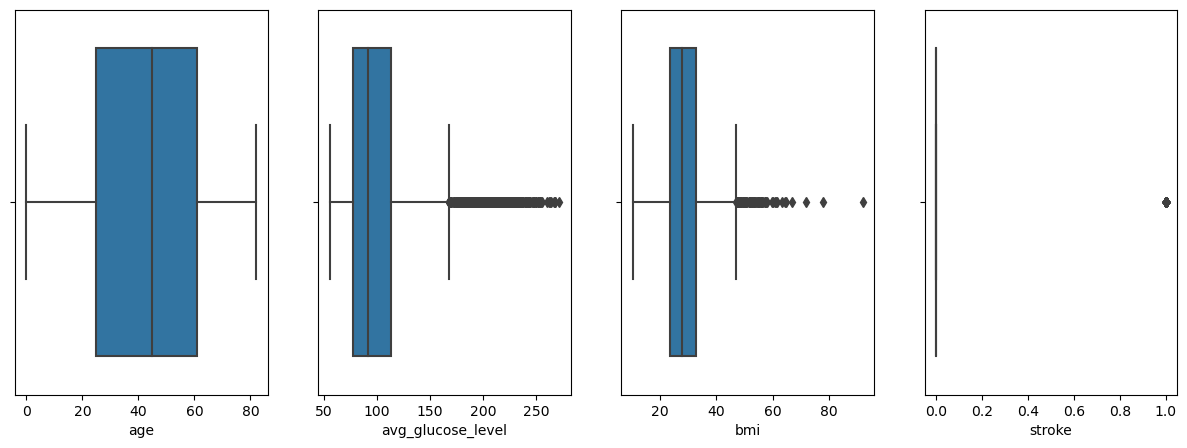

In [30]:
num_cols = stroke_eda.select_dtypes(include=["int", "float"]).columns

fig, ax = plt.subplots(1, len(num_cols), figsize=(15, 5))
for i in range(len(num_cols)):
    sns.boxplot(x=num_cols[i], data=stroke_eda, ax=ax[i])

There are some extreme values in glucose and bmi values. However, these extreme values are not unheard in real life. We won't be dropping these values. But extra steps will be taken to mark these extreme values later.

# Analysis

## Stroke

In order to predict stroke risk in a patient, we will use the historical data about patients who had a stroke. Let's understand the dataset by looking at the distribution of individuals who had a stroke before.

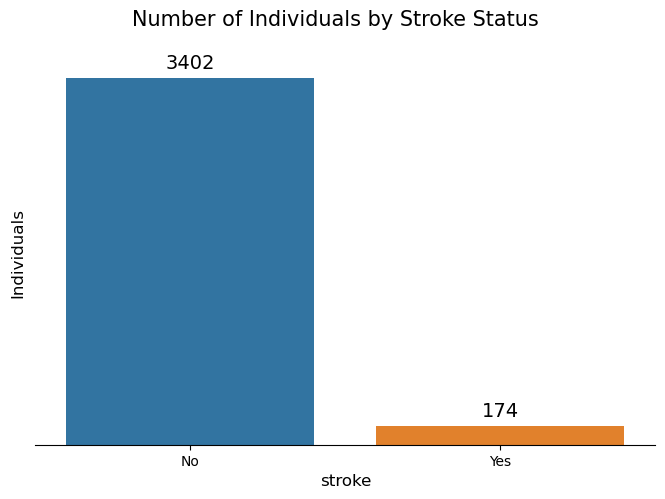

In [951]:
count_plots(
    x_col="stroke",
    y_col="Individuals",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Number of Individuals by Stroke Status",
    padding=4,
    label_color='black'
)

We don't expect to meet a lot of people who had a stroke in our daily lives. The graph shows that while 3889 people in this dataset had never had a stroke, 199 people had a stroke experience.  Individuals who had a stroke constitute a small minority in this dataset. The results are comparable to what we assumed. 

However, this shows an important aspect that we should consider with care. The target feature that we want to predict is imbalanced. This finding requires us to approach the classification problem with a special attitude. In order to have a reliable model, we will try appropriate measures to counter this problem.

Males and females may have different characteristics in terms of health. In order to see such a distinction exists in terms of stroke risk, we will take a closer look at stroke data with respect to gender. Before moving on let's see how different genders are represented in this dataset.

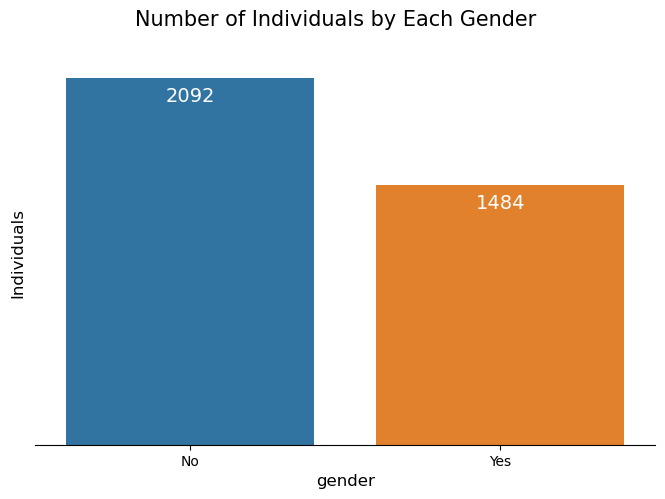

In [952]:
count_plots(
    x_col="gender",
    y_col="Individuals",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Number of Individuals by Each Gender",
    padding=-20
)

The gender representation in this dataset is more biased towards females. Although the difference is not dramatically high, males are represented less in the dataset. On the other hand, we can see that other genders are underrepresented, with only one individual defining their gender as other. 

Let's now go back to the data about stroke. We will see this data with a comparison of different genders.

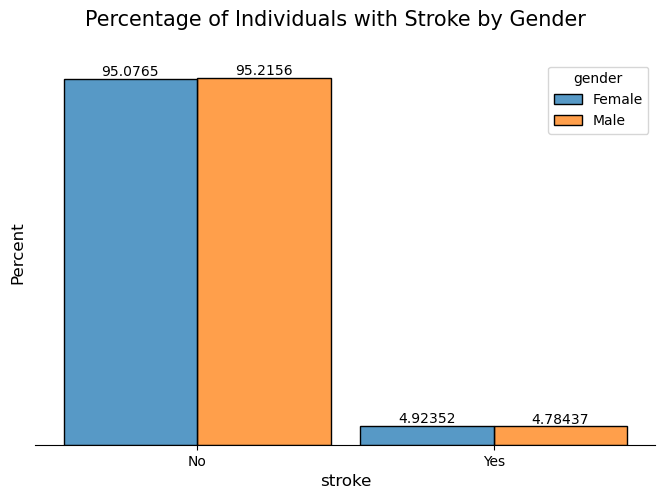

In [979]:
percent_plot(
    x="stroke",
    data=stroke_eda,
    hue="gender",
    title="Percentage of Individuals with Stroke by Gender",
)

Compared to the previous graph, the distribution of people from different genders who had not had a stroke look similar to the overall distribution of genders. 56% of all people in this dataset were female and never had a stroke. Males who had never had a stroke represent the 39% of all people. However, for those who had a stroke, the ratio of men seem to jump to rise to a level very close to females. Around 2.7% percent of people were female and had a stroke. Those who are male and had a stroke are 2.12% of all people in this dataset. There is a clear difference here. Even though they were the minority in this dataset, they have a very close ratio to females who had a stroke. Males seem to have a higher chance of stroke than females. 

Another important factor that should be considered in health is age. It is common knowledge that as a person ages, the health issues are bound to start appearing. We will see if that is the case in terms of stroke. Before moving on, let's see how different age groups are represented in this dataset.

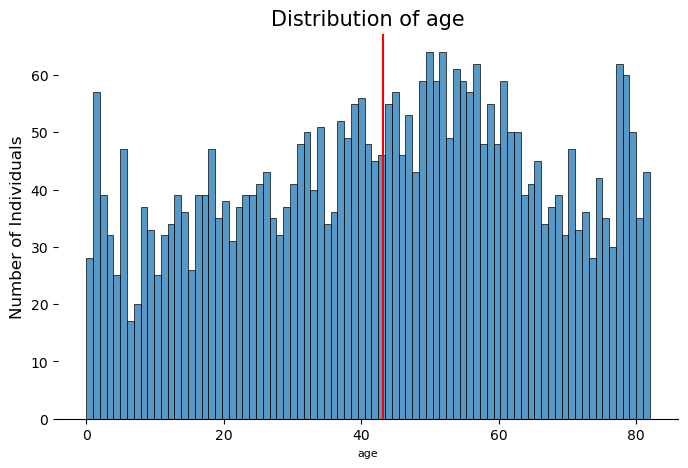

In [954]:
dist_plots(x_col="age", data=stroke_eda, bins=83)

In [35]:
print(stroke_eda["age"].mean())
print(stroke_eda["age"].median())
print(stroke_eda["age"].std())

43.238255033557046
45.0
22.70812680201377


The distribution of age is slightly right skewed. That means that we see more people with higher ages than 40 those who are younger than 40. However, the other side of the distribution is not completely empty. There are still many values representing young population. The mean age of this dataset is 43, which is around the halfway of the range we see in this dataset, which are 0-82. 

Another important insight here is that, we see the most number of people at extreme ages. The high representation of these two extreme value may need further investigation, as they may come from data errors. An explaination for this could be that when babies are born, their data are immediately collected. For old people, it can be speculated that they are more likely to be constantly in check with a hospital, so that their data are more constantly collected. 

Before moving on, let's verify the data to see whether the low ages actually denotes a baby's age.

In [36]:
baby = stroke_eda["age"] <= 5
assert (stroke_eda.loc[baby, "work_type"] == "children").all()

When we verify with another column of this dataset, we see that it confirms that the suspected range of age is actually about babies. 

Let's now go back and compare age values for people who had had a stroke before. 

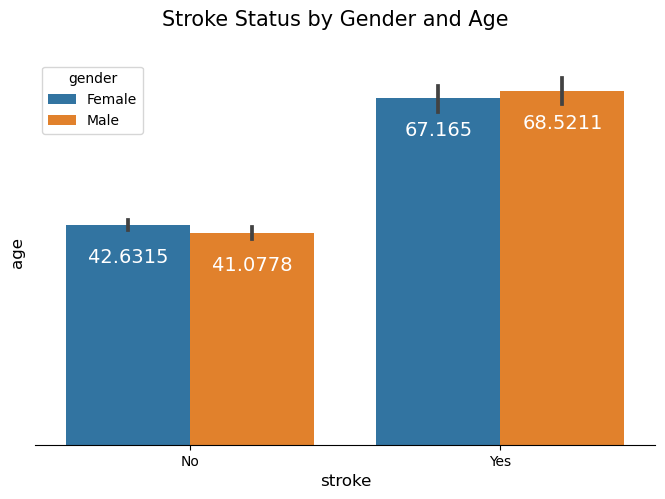

In [955]:
bar_compare(
    data=stroke_eda,
    x="stroke",
    y="age",
    tick_labels=["No", "Yes"],
    hue="gender",
    title="Stroke Status by Gender and Age",
)

Age seem to have a dramatic effect when we consider the risk of stroke. Average age of people who had not had a stroke before seem close to the average age of the dataset for both males and females. However, when we check the average age again for those who had had a stroke, the difference is visible. For females the value was 67, and, for males it was 69. This shows us clearly that old age is a contributing factor to stroke risk. 

## Heart Disease

CDC mentions that common heart diseases [increases](https://www.cdc.gov/stroke/risk_factors.htm#:~:text=Heart%20disease,rich%20blood%20to%20the%20brain.) the risk of stroke. Some diseases may decrease the oxygen rich blood flow to the brain. Others may cause blood clots. Whatever the case, heart diseases may be able to help our model understand stroke better. 

Let's first check how many people in this dataset have some kind of heart disease.

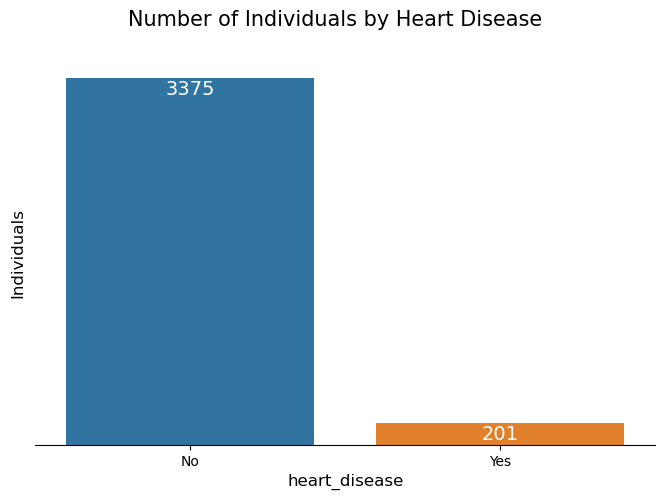

In [959]:
count_plots(
    x_col="heart_disease",
    y_col="Individuals",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Number of Individuals by Heart Disease",
    padding=-15
)

As expected most people whose data were collected do not have any heart diseases. We are interested in those who has a heart diseases to see whether they have a higher chance of stroke.

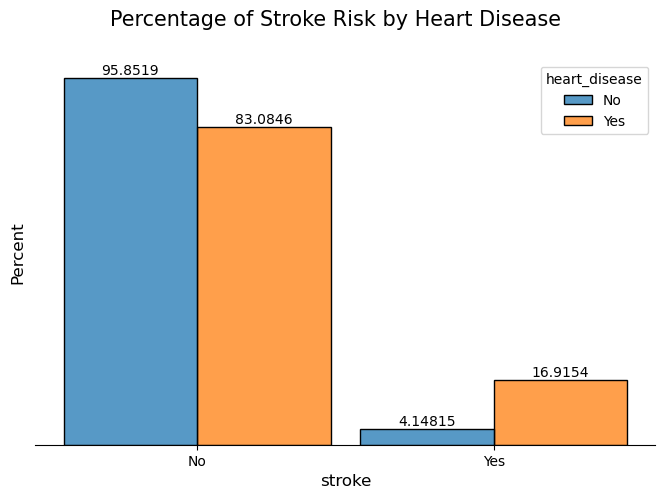

In [960]:
percent_plot(
    x="stroke",
    data=stroke_eda,
    hue="heart_disease",
    title="Percentage of Stroke Risk by Heart Disease",
)

16% of all people who do have a heart disease had a stroke. This value is higher than the value for those who do not have a heart disease and had a stroke. It looks like people with heart diseases have a higher risk of stroke. However, on the left side we see that the majority of people who has a heart disease had not had a stroke before. This means that while heart diseases are a driving factor for strokes, they do not necessarily result in a stroke in all cases. 

Let's now check the background of those who have a heart disease. It is widely known that smoking causes heart diseases. We will check if that assumption is true in this dataset.

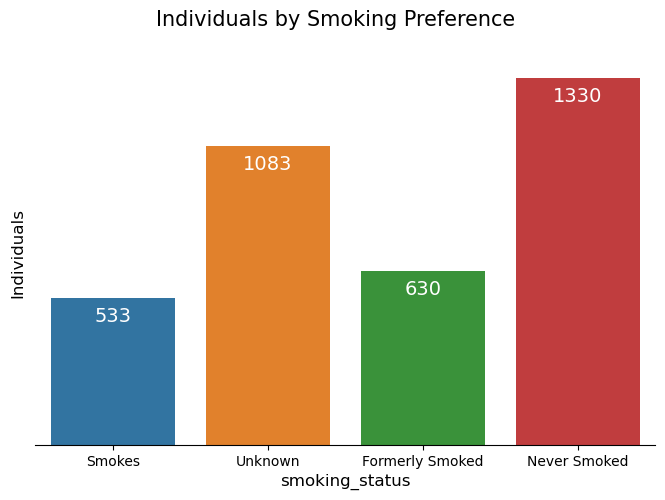

In [963]:
count_plots(
    x_col="smoking_status",
    data=stroke_eda,
    y_col="Individuals",
    tick_labels=["Smokes", "Unknown", "Formerly Smoked", "Never Smoked"],
    title="Individuals by Smoking Preference",
    padding=-20
)


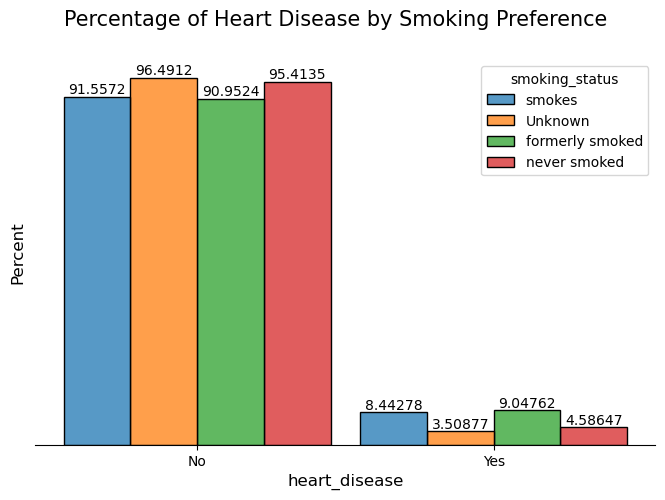

In [964]:
percent_plot(
    x="heart_disease",
    data=stroke_eda,
    hue="smoking_status",
    title="Percentage of Heart Disease by Smoking Preference",
)

Smoking status is denoted by four categories in this dataset. In addition to those who never smoked, smoked and formerly smoked, we have a category with a label 'Unknown'. This may represent those who did not answer the question or the data may not be available for these individuals.

For all cases, the majority of people did not have a heart disease. However when we look at those who have a heart disease, we can see that smokers and former smokers have a higher chance of heart diseases. 7% of those who smoke have a heart disease. Also 8% of individuals who smoked before have a heart disease. It is interesting to see that the latter group has a higher ratio of heart diseases. This could be due to higher or lower representation in either group, hence the difference in ratios of heart diseases.

## BMI

BMI or Body Mass Index describes the body fat based on height and weight of a person. The feature on its own may tell a good deal about the health of a patient, as high and low values in this feature communicate whether a patient is underweight, obese, or in a healthy weight. Typically a healthy person stands in the range of 18.5 to 24.9.

BMI is also one of the features that we want to predict in this project. So we will take a closer look at it on its own and in terms of its relationship to other characteristics of different patients.

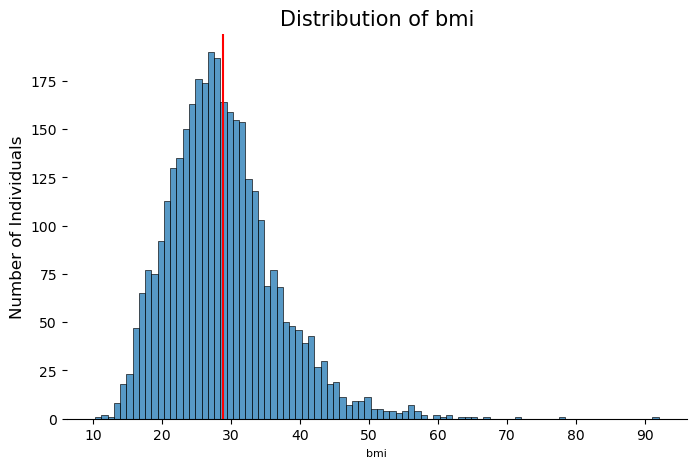

In [965]:
dist_plots(x_col="bmi", data=stroke_eda, bins=90)

In [43]:
print(stroke_eda["bmi"].mean())
print(stroke_eda["bmi"].median())
print(stroke_eda["bmi"].std())


28.79446870451234
27.9
7.851118185171999


Disregarding the long tail on right, we see that the values on the left build a normal distribution, which is fitting for a sample of this size. The values on the long tail, while not unheard of, are very rare to encounter in daily life. We will later handle these values when fitting a model.

Most people have around 28 BMI, which is a high value for a healthy person. This value is not however unexpected, as obesity is a common problem. 

Let's go back to heart diseases for a moment and see whether different weight types have relationship with heart diseases. 

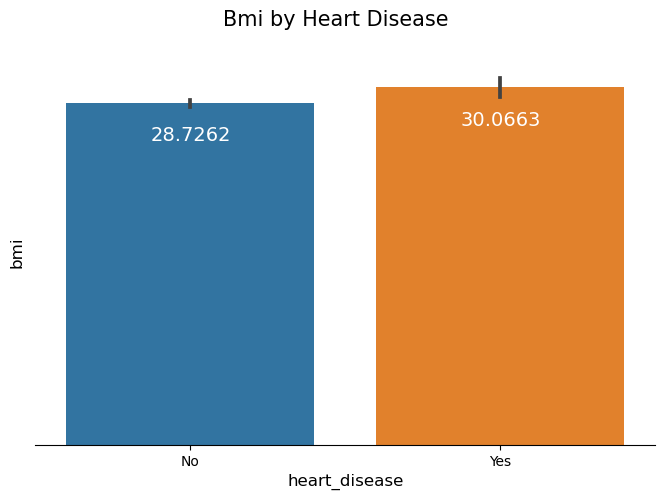

In [966]:
bar_compare(
    x="heart_disease",
    y="bmi",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Bmi by Heart Disease",
)


On average, people with a heart disease tend to have a higher bmi than those who do not. This may indicate that overweight people are more vulnerable to heart diseases. If that is true, this would be a very useful information for our case, as we already know that there is a relationship between heart diseases and strokes. 

We see that the average bmi values are very close between the groups of those who do not have a heart disease and those who have. In order to check the distinction, we will conduct a hypothesis test.

Considering all individuals in the dataset, do people with a heart disease have a higher bmi on average than those without one?

**Population**: All individuals

**Significance Level**: 0.05

**Parameter of Interest**: $\mu_1 - \mu_2$,  Difference of mean bmi

**Null Hypothesis**: $\mu_1 = \mu_2$

**Alternative Hypothesis**: $\mu_1 > \mu_2$

In [1002]:
with_heart_disease = stroke_eda['heart_disease'] == 'Yes'

In [1014]:
conf_int = zconfint(stroke_eda.loc[with_heart_disease, "bmi"].dropna())
print(f"Confidence interval for people with heart disease: {conf_int}")

Confidence interval for people with heart disease: (29.29389207226552, 30.83867935630589)


In [1015]:
conf_int = zconfint(stroke_eda.loc[~with_heart_disease, "bmi"].dropna())
print(f"Confidence interval for people without heart disease: {conf_int}")

Confidence interval for people without heart disease: (28.452852505424833, 28.999540132611973)


The group representing people with a heart disease seem to have a higher band of average bmi values than the latter group. Confidence intervals tell us that these groups may actually be different.

In [1016]:
test_stat, p_value = ztest(
    stroke_eda.loc[with_heart_disease, "bmi"].dropna(),
    stroke_eda.loc[~with_heart_disease, "bmi"].dropna(),
    alternative="larger",
)
print(
    f"Test statistic: {test_stat}\n\
p-value: {p_value}"
)

Test statistic: 2.200947368152702
p-value: 0.013869875017248736


Concluding our ztest, we find out that there is enough statistical evidence to reject the null hypothesis. Null hypothesis stated that there was no difference between people with heart disease and without heart disease in terms of average bmi. However, here we found out that people with a heart disease actually have a slightly higher average bmi.

Obesity may also have direct impact on strokes. [Studies](https://ochsnerlg.org/about-us/news/how-obesity-affects-stroke-risk) suggest that each unit increase in BMI increases the risk of strokes by 5 percent. Let's now take a closer look at this relationship to see if that assumption is true for our dataset.  

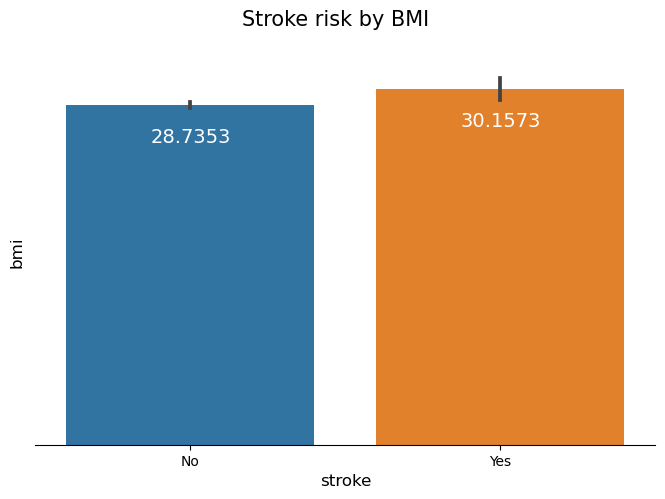

In [967]:
bar_compare(
    x="stroke",
    y="bmi",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Stroke risk by BMI",
)

The average bmi values for both cases, namely people who had not had a stroke and people who had had a stroke, look very similar to those with and without a heart disease. It looks like bmi of around 30 may be a dangerous value, which may lead to problems like stroke and heart disease. But what does it look when a patient has both?

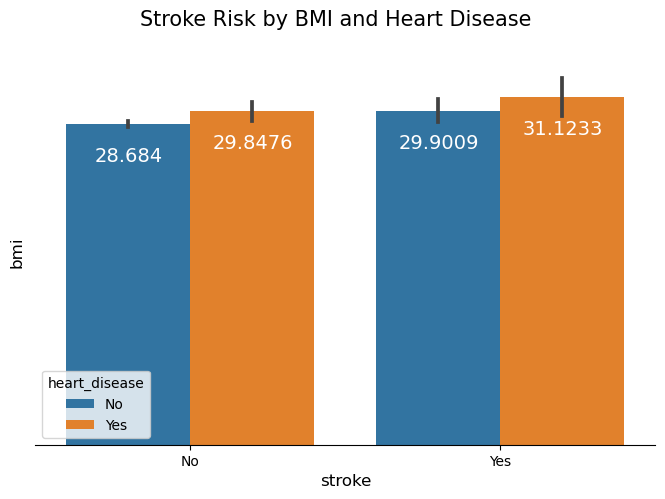

In [968]:
bar_compare(
    x="stroke",
    y="bmi",
    data=stroke_eda,
    hue="heart_disease",
    tick_labels=["No", "Yes"],
    title="Stroke Risk by BMI and Heart Disease",
)

When a patient has a heart disease and had a stroke, the average bmi value for those individuals seem to be higher than individual cases. It should be noted here that, this group has a large error bar, which indicates a less confidence in our average value. 

Overall, we understand from the graphs that bmi has a direct or indirect affect on other health conditions such as heart diseases and strokes. It should come as no surprise, as it is common knowledge that obese individuals are more prone to health complications.

## Hypertension

[Blood pressure](https://www.cdc.gov/bloodpressure/about.htm) is the pressure of blood pushing against the walls of arteries. Arteries carry blood from heart to other parts of the body.

High blood pressure, also called hypertension, is the condition where blood pressure is higher than normal. This condition may lead to several health issues. In our case, we want to see if the presence of hypertension usually accompanied by other health condition of our interest, such as heart diseases and stroke.

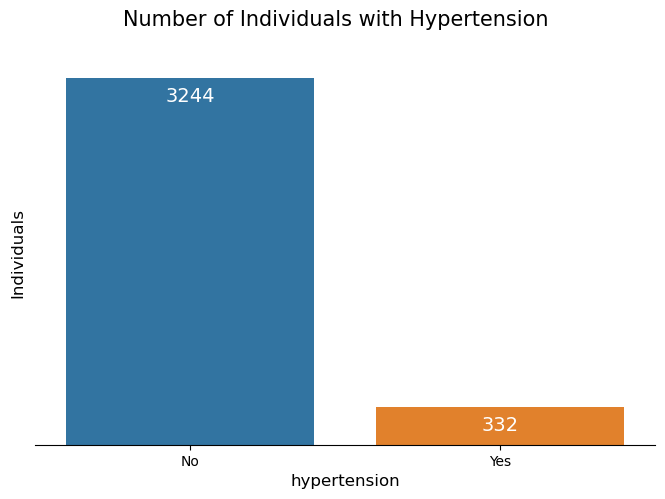

In [970]:
count_plots(
    x_col="hypertension",
    y_col="Individuals",
    data=stroke_eda,
    title="Number of Individuals with Hypertension",
    tick_labels=["No", "Yes"],
    padding=-20
)

Individuals with a hypertension problem are the minority in our dataset. We will now check how hypertension relates to other conditions.

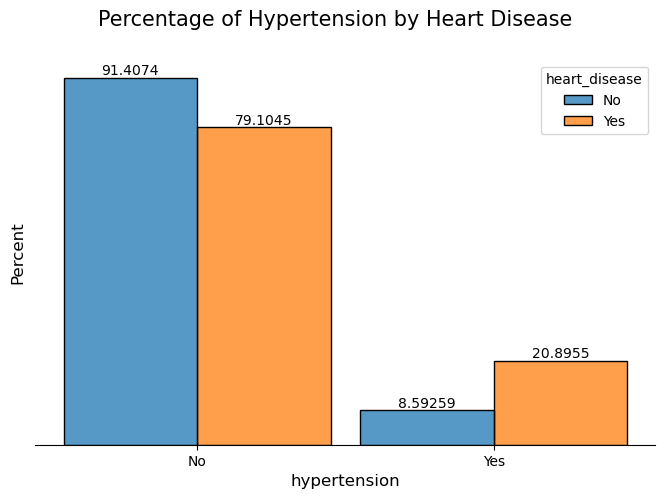

In [971]:
percent_plot(
    x="hypertension",
    data=stroke_eda,
    hue="heart_disease",
    title="Percentage of Hypertension by Heart Disease",
)

Most people, whether with a heart condition or not, did not report hypertension. However, for those who did, we see that 21 percent of people who has a heart disease also has hypertension. This is higher than the value of 9 percent for the group which represents those without a heart disease and had a hypertension. So, it looks like people with a heart disease may be more likely to also have hypertension. Perhaps unhealthy blood pressure levels are a cause for heart diseases.

Let's now look at the relationship between hypertension and strokes.

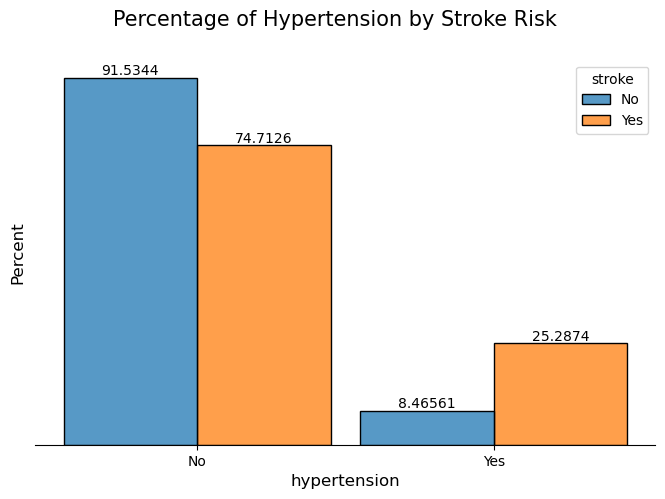

In [972]:
percent_plot(
    x="hypertension",
    data=stroke_eda,
    hue="stroke",
    title="Percentage of Hypertension by Stroke Risk",
)

We now see a more dramatic difference between groups. Again the majority of people whether with had a stroke or not, did not report a hypertension problem. The important insight lies in the left sight of this graph. 27 percent of individuals who has a hypertension problem had experienced a stroke. This shows a clear relationship between these two conditions.

We have seen that hypertension is often accompanied with other health problems. These conditions may be a direct result of hypertension, or they may be the side effects of the conditions hypertension causes. 

But what causes hypertension? Let's look at some data that may be related to this condition.

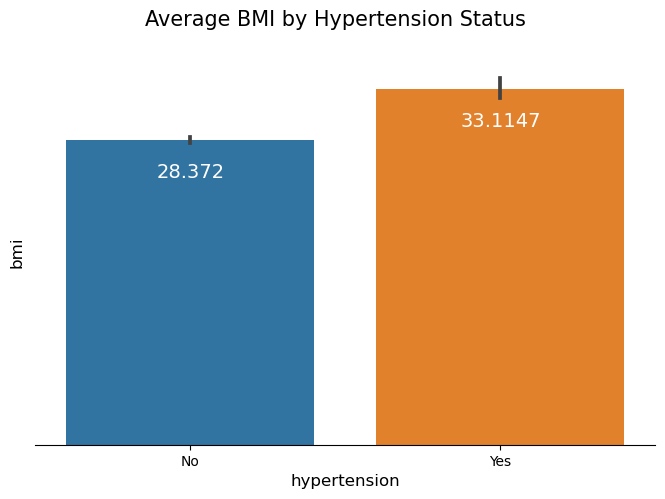

In [973]:
bar_compare(
    x="hypertension",
    y="bmi",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Average BMI by Hypertension Status",
)

The comparisons with bmi seem to follow a pattern with different health conditions. Hypertension is no different. We see here that individuals with hypertension tend to have a much higher bmi. The average value we see is in the range of obesity, which is 33. It looks like overweight individuals may be more prone to hypertension and as a result to other conditions such as heart diseases and strokes. 

We suspect that smoking could also could be a factor that lead to hypertension. Let's check this assumption.

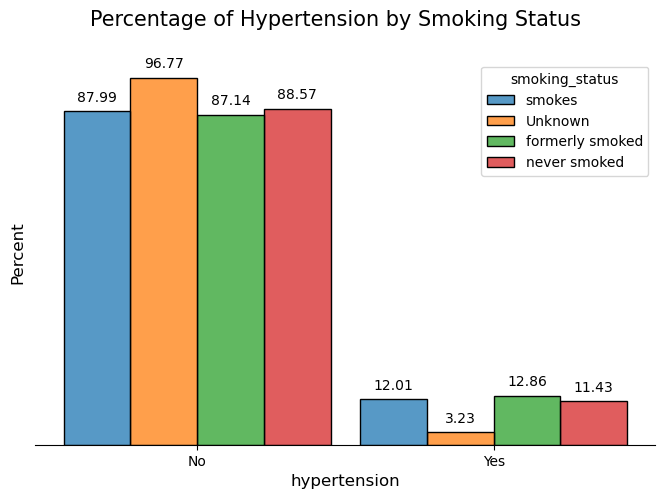

In [984]:
percent_plot(
    x="hypertension",
    data=stroke_eda,
    hue="smoking_status",
    title="Percentage of Hypertension by Smoking Status",
)

For most different smoking habits, the results seem very similar. There may not be enough evidence to say that smokers or non-smokers are more prone to hypertension. There is one surprising insight here though. We see that those whose preference are not known tend to have much lower ratio for hypertension. Perhaps these people are special in some other way that they often do not have any hypertension problem.

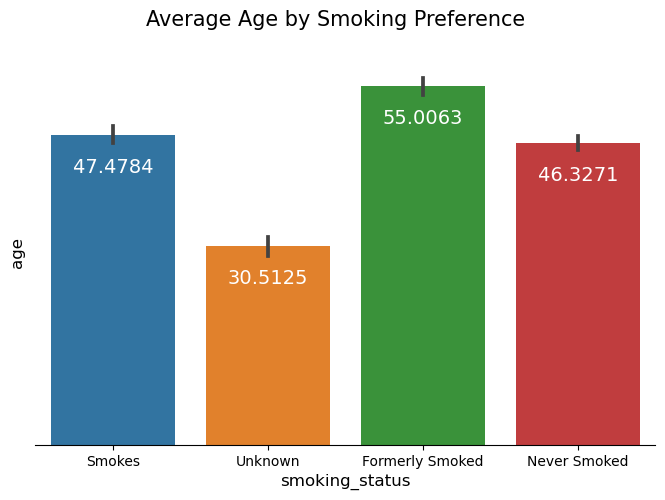

In [975]:
bar_compare(
    x="smoking_status",
    y="age",
    data=stroke_eda,
    tick_labels=["Smokes", "Unknown", "Formerly Smoked", "Never Smoked"],
    title="Average Age by Smoking Preference",
)

The people whose smoking habits are much younger on average. Perhaps this group is mostly consisted of children and simply they may not be asked about their smoking habits.

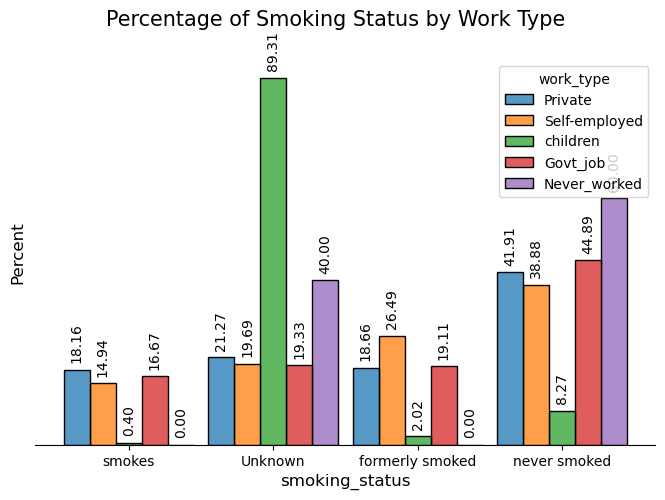

In [983]:
percent_plot(
    x="smoking_status",
    data=stroke_eda,
    hue="work_type",
    title="Percentage of Smoking Status by Work Type",
    rotate_labels=90
)

Our assumption was true. 90 percent of children's smoking preferences are simply encoded as unknown. There may be a couple reasons behind that. But what is important is we now know a characteristic behind this group called unknown. We have also discovered that younger people may be less vulnerable to hypertension problem. Let's confirm this as the last step here.

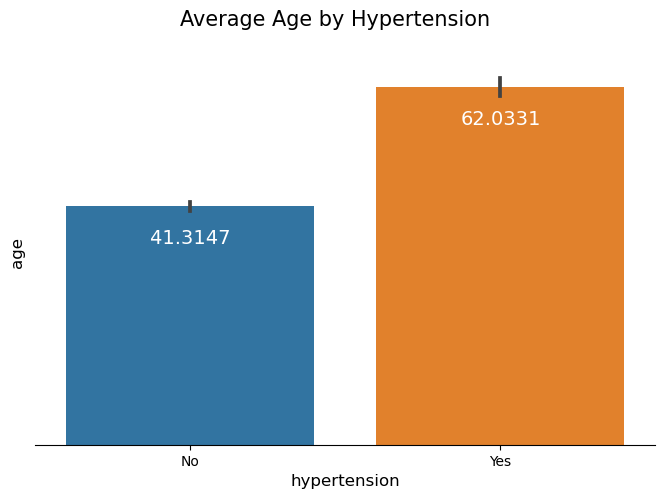

In [986]:
bar_compare(
    x="hypertension",
    y="age",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Average Age by Hypertension",
)

As assumed, individuals with hypertension tend to be older with an average age of 62. This is a clear difference when compared to those without hypertension, which averaged 41 years. This value is also very similar to the average age of the dataset. From here we can understand that as people get older, blood pressure also increases.

## Glucose

Glucose, also called blood sugar, is the main sugar found in [blood](https://medlineplus.gov/bloodsugar.html). This is the main form of energy that is used by the body to perform tasks. While glucose is needed, it can be dangerous in high or low levels. In very high levels, the condition is called diabetes. Individuals with diabetes are twice as more likely to have a [stroke](https://www.stroke.org/en/about-stroke/stroke-risk-factors/diabetes-and-stroke-prevention). 

Understanding glucose levels seem to be very important to predict other health conditions such as stroke. In our case, we won't be labelling any patient with diabetes, as we are not medical practitioners. However, we will label the names for very high and low blood sugar levels without diagnosing any conditions. When blood sugar level is higher than 200, this condition is called Hyperglycemia. When the level drops lower than 70, this is called Hypoglycemia. 

We want to understand how glucose levels are related to other conditions. Let's first look at the distribution of glucose in our dataset.

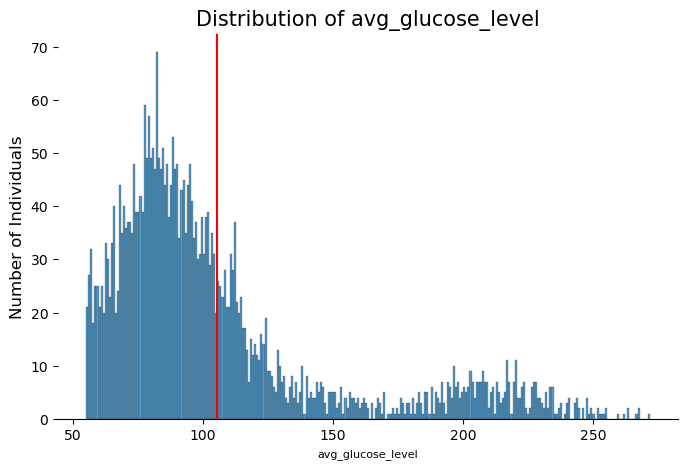

In [987]:
dist_plots(x_col='avg_glucose_level', data=stroke_eda, bins=275)

We see two peaks in our distribution of average glucose levels. The first one seem to be centered around healthy values which ranges between 75 to 100. The other small peak is around high blood sugar levels which are higher than 200, which indicates a condition called hyperglycemia. The individuals in the second peak may or may not be suffering from diabetes. Overall, we understand that the distributions represent a wide variety of glucose levels. 

Now let's take a look at different features that could be contributing to glucose levels.

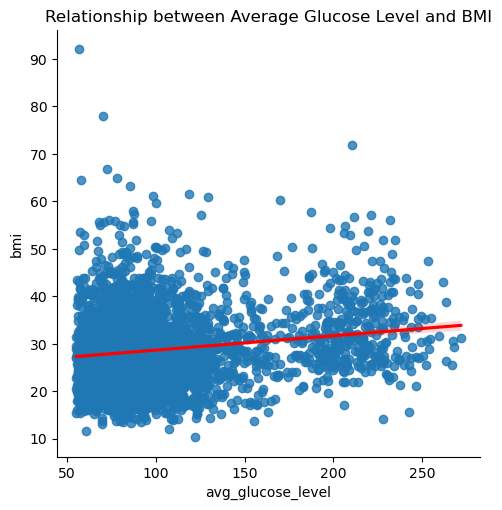

In [988]:
sns.lmplot(x="avg_glucose_level", y="bmi", data=stroke_eda, line_kws={"color": "red"})
plt.title('Relationship between Average Glucose Level and BMI')
plt.show()

In [57]:
stroke_eda["avg_glucose_level"].corr(stroke_eda[stroke_eda["bmi"] < 50]["bmi"])

0.1722130660935442

When we compare the glucose levels to bmi, we see a weak correlation between these two values. In some cases we expect the individuals with high bmis to have a higher average glucose level. This means that people suffering from obesity may be more likely to have high sugar levels in their blood. 

Now let's see what different blood sugar levels mean for our case. We want to see whether these levels have any affect on a patient's risk of having a stroke and heart disease.

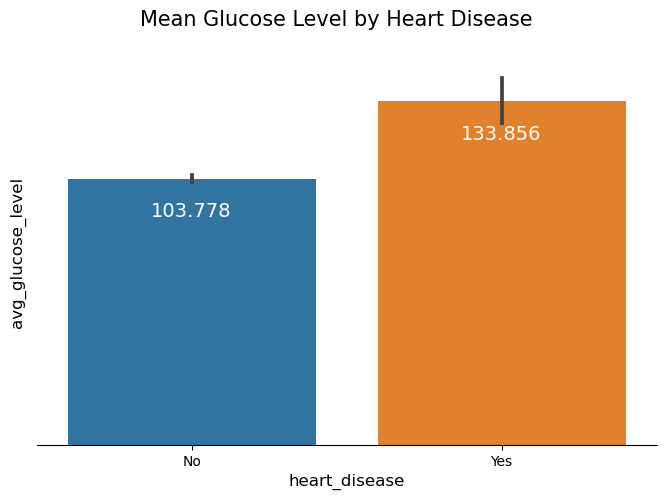

In [989]:
bar_compare(
    x="heart_disease",
    y="avg_glucose_level",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Mean Glucose Level by Heart Disease",
)

The graph shows that on average people with heart diseases had a much higher level of average blood sugar. High glucose may or may not be directly related to heart problems. But the difference between groups is important for our case, as we have already found out that heart diseases are a good indicator about stroke risk. 

Let's now look at the direct relationship between glucose levels and stroke risk.

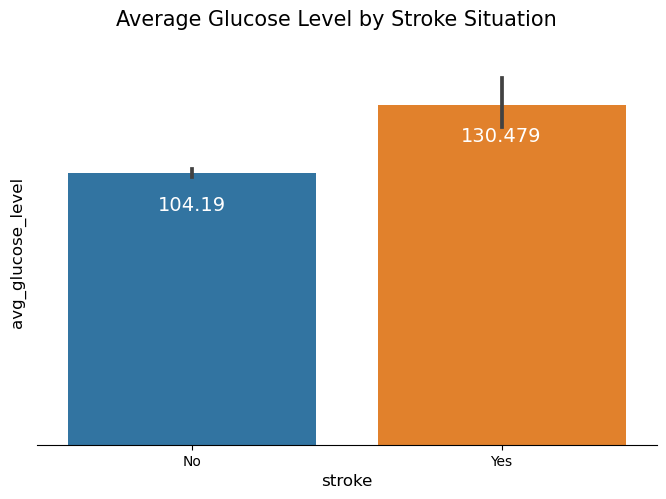

In [990]:
bar_compare(
    x="stroke",
    y="avg_glucose_level",
    data=stroke_eda,
    tick_labels=["No", "Yes"],
    title="Average Glucose Level by Stroke Situation",
)

Individuals who had had a stroke before has a much higher average glucose levels. This shows that the presence of high levels of blood sugar may be related to stroke. This may also suggest a relationship between diabetes and strokes. 

<AxesSubplot:>

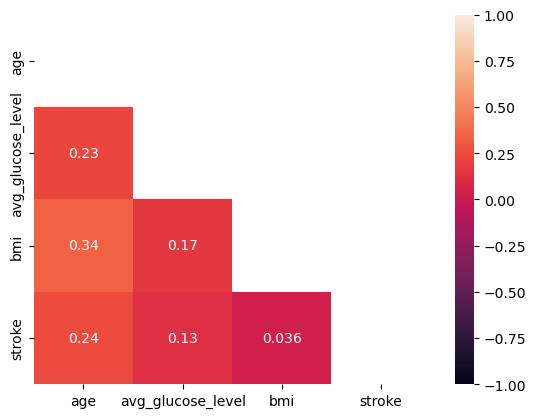

In [60]:
fig, ax = plt.subplots()
mask = np.triu(np.ones_like(stroke_eda.corr()))
sns.heatmap(stroke_eda.corr(), annot=True, ax=ax, vmax=1, vmin=-1, mask=mask)


Correlations that the denote the relationships between numerical columns confirm what we have seen in our data discovery. 

The strongest relationship here is between bmi and age. This means that as a person grows in age, they may have a higher bmi. We have found out that higher bmis usually followed with health problems. In our case this information is quite useful. Also, older ages seem to have a bit higher glucose levels, which also has a relationship with other health problems. It looks like age has an indirect effect on some health problems.

Lastly, we see that there is a small relationship between bmi and glucose levels. As suggested before, this may mean that on certain cases overweight people may have higher glucose levels.

<AxesSubplot:>

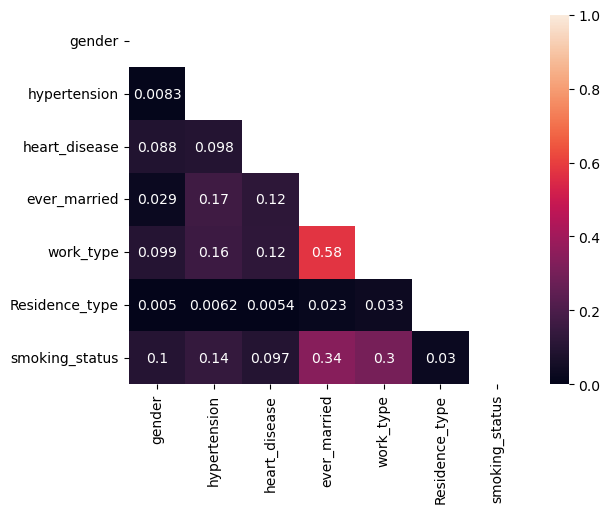

In [61]:
cat_stroke = stroke_eda.apply(lambda x: x.astype("category") if x.dtype == "O" else x)

cramersv = am.CramersV(cat_stroke)
mask = np.triu(np.ones_like(cramersv.fit()))
sns.heatmap(cramersv.fit(), annot=True, vmax=1, vmin=0, mask=mask)

Most categorical features do not have a strong relationship. However, there are some relationships that is important to note.

Work type and ever married status have the strongest relationship here. This makes sense as we know that work type includes the category children, and we don't expect those individuals to be married. So the relationship may be about this. The same can be said about work type vs. smoking status. Most children were reported as unknown on their smoking status, this could be the relationship this graph is capturing. 

It may also be the same case with ever married status and smoking status. However, this could also suggest a relationship between married people and smoking habits.  

# Machine Learning Models

## Stroke Prediction

In this section, we will create a model that is able to identify a patient's stroke risk by looking at certain data. In order to find a reliable model, we will start with simple models to test their performances. We will move on to see how more complicated models work for this task. Later we will create some new features using several feature engineering techniques. We will finally complete the model by searching for the best parameters for this task, and eliminating unnecessary features. 

### Simple Models

In [62]:
classifiers = [
    LogisticRegression(random_state=1, class_weight="balanced"),
    SVC(random_state=1, class_weight="balanced", probability=True),
    DecisionTreeClassifier(random_state=1, class_weight="balanced"),
    GaussianNB(),
    KNeighborsClassifier(),
]

In [63]:
cross_val = cross_validate_model(classifiers, X_train, y_train, pipeline=True)
cross_val.style.background_gradient(cmap="Reds")

In this problem, we are firstly interested in recall score. This is because we want to identify all patients with a stroke risk, even if we identify those who do not have any risk. 

Decision Tree Classifier has the best score on training, however this is because the model is overfitting the data and memorizing the patterns in the training data. This won't generalize well to new data. All other models are making similar errors, performing better on the training data and resulting in lower scores in test data. We need to address the overfitting problem first.

In [64]:
classifiers = [
    LogisticRegression(random_state=1, class_weight="balanced", C=0.5),
    SVC(random_state=1, class_weight="balanced", C=0.5, probability=True),
    DecisionTreeClassifier(
        random_state=1, class_weight="balanced", max_depth=3, ccp_alpha=0.05
    ),
    GaussianNB(),
    KNeighborsClassifier(),
]

In [65]:
cross_val = cross_validate_model(classifiers, X_train, y_train)
cross_val.style.background_gradient(cmap="Reds")

By penalizing the model's capacity to overlearn, we ended up with models that are performing better on the test data. In this case, Decision Tree Classifier is no longer predicting the labels of the training data perfectly. On the test set it has the best recall score, which is 0.95. This means that this model is able to correctly identify 95 percent of all people with stroke risk. However we see that this model has a very low precision score. Out of all the predictions this model made, only 10 percent of them were actually carrying stroke risk. Low precision may cause high operational costs as more tests will be done for people who simply did not have any risk. 

Let's try to improve our models by making a simple adjustment.

### Simple Models with Sampling

This dataset is extremely imbalanced. People who had had a stroke before are a minority. This limits the ability of our models to understand the reasons behind a stroke. In order to combat this situation, we will upsample the minority class and give the model more examples to learn. 

In [66]:
stroke_preprocessor_1 = make_preprocessor(X_train, scaler=False)


In [67]:
X_train_sampled = stroke_preprocessor_1.fit_transform(X_train)


In [68]:
X_train_sampled = stroke_preprocessor_1.fit_transform(X_train)
X_train_sampled = return_col_names(
    X_train_sampled, preprocessor=stroke_preprocessor_1)


In [69]:
over = SMOTE(sampling_strategy=0.12)
under = RandomUnderSampler(sampling_strategy=0.12)
steps = [("o", over), ("u", under)]
smote_pipeline = SMOTEPipeline(steps=steps)
X_train_sampled, y_train_sampled = smote_pipeline.fit_resample(X_train_sampled, y_train)

In [70]:
classifiers = [
    LogisticRegression(random_state=1),
    SVC(random_state=1, probability=True),
    DecisionTreeClassifier(random_state=1),
    GaussianNB(),
    KNeighborsClassifier(),
]

In [71]:
cross_val = cross_validate_model(classifiers, X_train_sampled, y_train=y_train_sampled)
cross_val.style.background_gradient(cmap="Reds")

We tried the upsampled data with unpenalized models first. As expected the results are very similar to what we have seen before. Models are overfitting to the data. Let's try the penalized models instead.

In [72]:
classifiers = [
    LogisticRegression(random_state=1, class_weight="balanced", C=0.5),
    SVC(random_state=1, class_weight="balanced", C=0.5, probability=True),
    DecisionTreeClassifier(
        random_state=1, class_weight="balanced", max_depth=3, ccp_alpha=0.05
    ),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=2),
]

In [73]:
cross_val = cross_validate_model(classifiers, X_train_sampled, y_train=y_train_sampled)
cross_val.style.background_gradient(cmap="Reds")

For most of our models, test scores improved. The best performing model here is again Decision Tree Classifier, which was able to have a recall score of 96 percent and precision of 21 percent. The precision score is especially better for this model, as we now know that 21 percent of our prediction were actually people with stroke risk.

In the second place SVC model was able to reach a recall score of 86 percent. While this is lower than our first model, this model was able to achieve a higher precision score, 32 percent. 

These two models seem to be doing a good job. Let's now try some more complex models to see if this approach would improve our performance.

### Ensemble Models

In [74]:
ensemble = [
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
]

In [75]:
cross_val = cross_validate_model(
    classifiers=ensemble, X_train=X_train, y_train=y_train, scaler=False
)
cross_val.style.background_gradient(cmap="Reds")

Ensemble models seem to be overfitting similar to the Decision Tree. In all cases, we see very low recall scores. Let's see if we can improve their performances by applying some regularization.

In [76]:
ensemble = [
    RandomForestClassifier(
        random_state=42,
        max_depth=3,
        class_weight="balanced_subsample",
        ccp_alpha=0.01,
        max_leaf_nodes=10,
        max_features="log2",
    ),
    AdaBoostClassifier(
        DecisionTreeClassifier(
            class_weight="balanced", max_depth=1, max_features="log2", max_leaf_nodes=10
        ),
        random_state=42,
        learning_rate=0.5,
    ),
    GradientBoostingClassifier(random_state=42, max_depth=3, learning_rate=0.1),
]

In [77]:
cross_val = cross_validate_model(
    classifiers=ensemble, X_train=X_train, y_train=y_train, scaler=False
)

In [78]:
cross_val.style.background_gradient(cmap="Reds")

With regularization, the models generalize much better on test data. Random Forest and AdaBoost had comparable recall scores to the ones we have seen before. Let's now see if we can further improve the results by training on the upsampled data.

### Ensemble Models with Sampling

In [79]:
ensemble = [
    RandomForestClassifier(random_state=42, max_depth=3, class_weight="balanced"),
    AdaBoostClassifier(
        DecisionTreeClassifier(class_weight="balanced", max_depth=1),
        random_state=42,
        learning_rate=0.5,
    ),
    GradientBoostingClassifier(random_state=42, max_depth=5, learning_rate=0.05),
]

In [80]:
cross_val = cross_validate_model(
    ensemble, X_train_sampled, y_train=y_train_sampled, scaler=False
)

In [81]:
cross_val.style.background_gradient(cmap="Reds")

After upsampling, the ensemble models became good candidates to be one of our final models. Although they perform worse in terms of recall compared to Decision Tree, they score slightly higher in precision. Let's see if we can find better candidates by checking even more complex models.

### Gradient Boosting

In [82]:
classes_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

In [83]:
gradient = [
    XGBClassifier(
        random_state=42,
        verbosity=0,
        max_depth=2,
        gamma=0.5,
        sample_weight=classes_weights,
        early_stopping_rounds=15,
    ),
    LGBMClassifier(
        random_state=42,
        max_depth=2,
        reg_alpha=0.5,
        verbosity=0,
        class_weight="balanced",
        subsample=0.2,
    ),
    CatBoostClassifier(
        random_state=42,
        depth=2,
        verbose=False,
        auto_class_weights="Balanced",
        eta=0.05,
        early_stopping_rounds=15,
    ),
]

In [84]:
cross_val = cross_validate_model(
    gradient, X_train=X_train, y_train=y_train, scaler=False
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [85]:
cross_val.style.background_gradient(cmap="Reds")

Complex gradient boosting models do not give good results in the metrics we are interseted in. Let's check this again with upsampled data.

### Gradient Boosting with Sampling

In [86]:
gradient = [
    XGBClassifier(
        random_state=42,
        verbosity=0,
        max_depth=2,
        gamma=0.5,
        early_stopping_rounds=15,
        scale_pos_weight=10,
    ),
    LGBMClassifier(
        random_state=42,
        max_depth=2,
        reg_alpha=0.5,
        verbosity=0,
        class_weight="balanced",
        subsample=0.2,
    ),
    CatBoostClassifier(
        random_state=42,
        depth=2,
        verbose=False,
        early_stopping_rounds=15,
        scale_pos_weight=10,
    ),
]

In [87]:
cross_val = cross_validate_model(
    gradient, X_train_sampled, y_train=y_train_sampled, scaler=False
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [88]:
cross_val.style.background_gradient(cmap="Reds")

After upsampling, Catboost is able to improve its performance and reach to a comparable level to Decision Tree. It also has a comparatively high performance in precision. 

Also the log loss seem to be much lower for all models here than the earlier models we have seen. For this reason, we will be moving on with these gradient boosting models.

### Feature Engineering

In this section, we will apply some feature engineering and see whether new information will result in model's ability to predict correctly.

In [89]:
X_train_sampled_ft = add_features(X_train_sampled)


In [90]:
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


In [91]:
best_models = [
    XGBClassifier(
        random_state=42,
        verbosity=0,
        reg_alpha=0.5,
        early_stopping_rounds=15,
        scale_pos_weight=pos_weight,
        max_depth=3,
    ),
    LGBMClassifier(
        random_state=42,
        max_depth=3,
        reg_alpha=5,
        verbosity=-100,
        scale_pos_weight=pos_weight,
        force_row_wise=True,
    ),
    CatBoostClassifier(
        random_state=42,
        l2_leaf_reg=5,
        learning_rate=0.02,
        verbose=False,
        early_stopping_rounds=15,
        scale_pos_weight=pos_weight,
        random_strength=10,
        max_depth=3,
    ),
]

In [92]:
cross_val_ref = cross_validate_model(
    best_models, X_train_sampled, y_train=y_train_sampled, scaler=False
)

In [93]:
cross_val_ref.style.background_gradient(cmap="Reds")

We made a small change to the models' hyperparameters, so that it can understand the original imbalanced distribution of our dataset. This change resulted in higher recall for some of our models. However this made the precision and log loss to decrease slightly. However this is still better than the earlier models we have seen.

In [94]:
cross_val_ft_1 = cross_validate_model(
    best_models, X_train_sampled_ft, y_train=y_train_sampled, scaler=False
)

In [95]:
cross_val_ft_1.style.background_gradient(cmap="Reds")

New features improved the performance of LightGBM and Catboost. However, XGBoost is still suffering from overfitting and new features actually decreased the performance. After this step, we will eliminate XGBoost and work with rest of the models. 

Let's now see how different features seem to affect our models' decision.

LGBMClassifier(force_row_wise=True, max_depth=3, random_state=42, reg_alpha=5,
               scale_pos_weight=19.551724137931036, verbosity=-100)


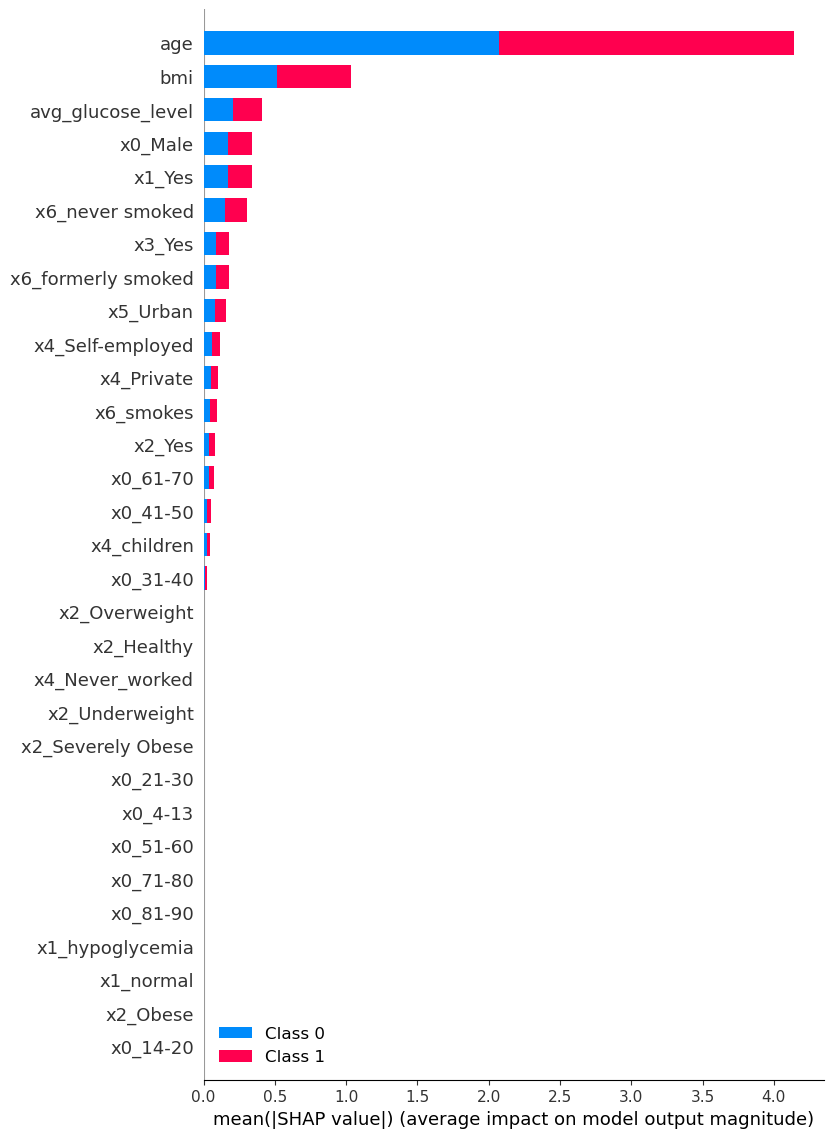

In [96]:
shap_values = shap_viz(
    best_models[1], X_train_sampled_ft, y_train_sampled, kind="tree", scaled=False
)

LightGBM model does not take into account most of the features we created. This may actually cause overfitting. In later sections we will try feature elimination to delete the features that are not used by the model.

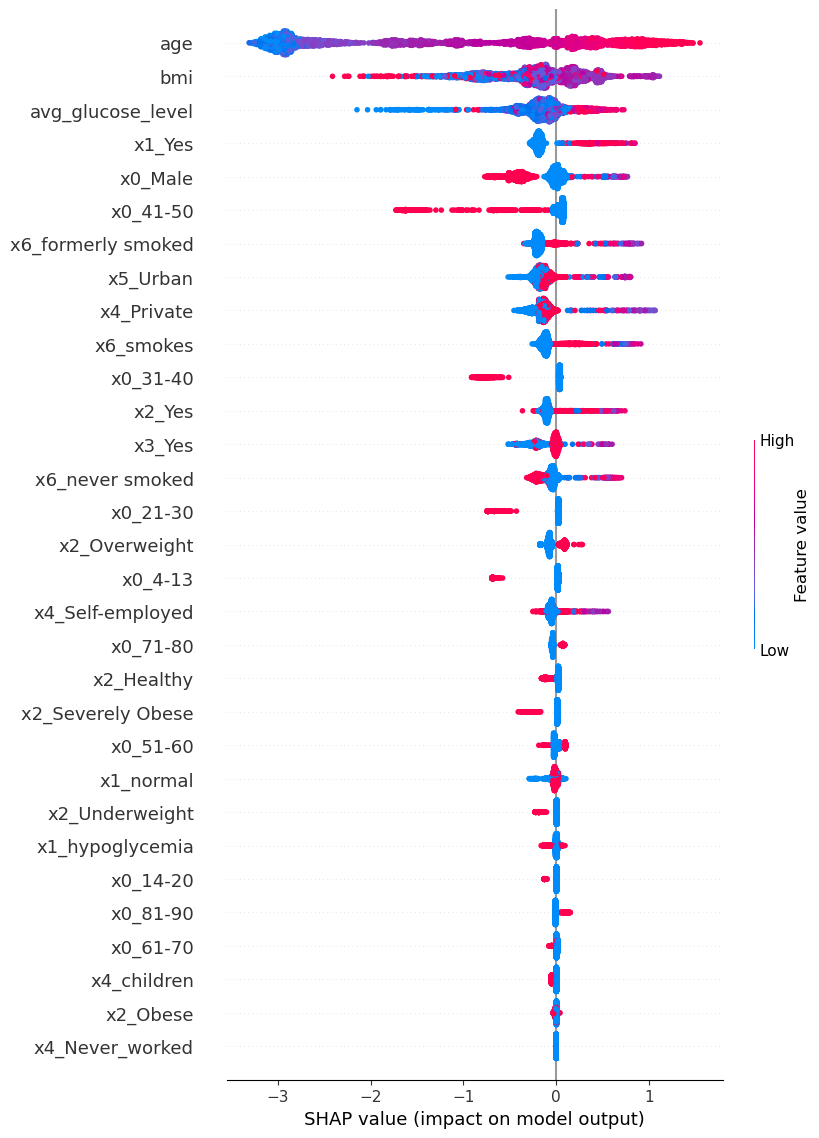

In [97]:
shap_values = shap_viz(
    best_models[2], X_train_sampled_ft, y_train_sampled, "tree", scaled=False
)

On the other hand Catboost seem to use many more features while it's making a decision. However, there are still some features that were not used for prediction. We will eliminate these later.

Now let's create more function by using a library. This library will automatically calculate different mathematical operations between features. This may help the model to understand the relationships better. 

In [98]:
auto_features = Autofeaturetool(X_train_sampled, y_train_sampled, task="classification")

[AutoFeat] Warning: This just calls fit_transform() but does not return the transformed dataframe.
[AutoFeat] It is much more efficient to call fit_transform() instead of fit() and transform()!
[AutoFeat] The 2 step feature engineering process could generate up to 5565 features.
[AutoFeat] With 3808 data points this new feature matrix would use about 0.08 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 57 transformed features from 15 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 2451 feature combinations from 2556 original feature tuples - done.
[feateng] Generated altogether 2606 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 1862 additional features
[featsel] Scaling data...done.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[featsel] Feature selection run 2/5
[featsel] Feature se

In [99]:
X_train_sampled_ft_auto = auto_features.transform(X_train_sampled)


[AutoFeat] Computing 22 new features.
[AutoFeat]    22/   22 new features ...done.


In [100]:
X_train_sampled_ft_auto = add_features(X_train_sampled_ft_auto)


In [101]:
cross_val_ft_cat_cl_auto = cross_validate_model(
    [best_models[2]], X_train_sampled_ft_auto, y_train=y_train_sampled, scaler=False
)

In [102]:
cross_val_ft_cat_cl_auto.style.background_gradient(cmap="Reds")

Adding all of the features led the model to decrease in recall performance. However, it incrased the precision score. High number of features may be causing the model to overfit. Let's see how each feature is affecting the prediction outcome.

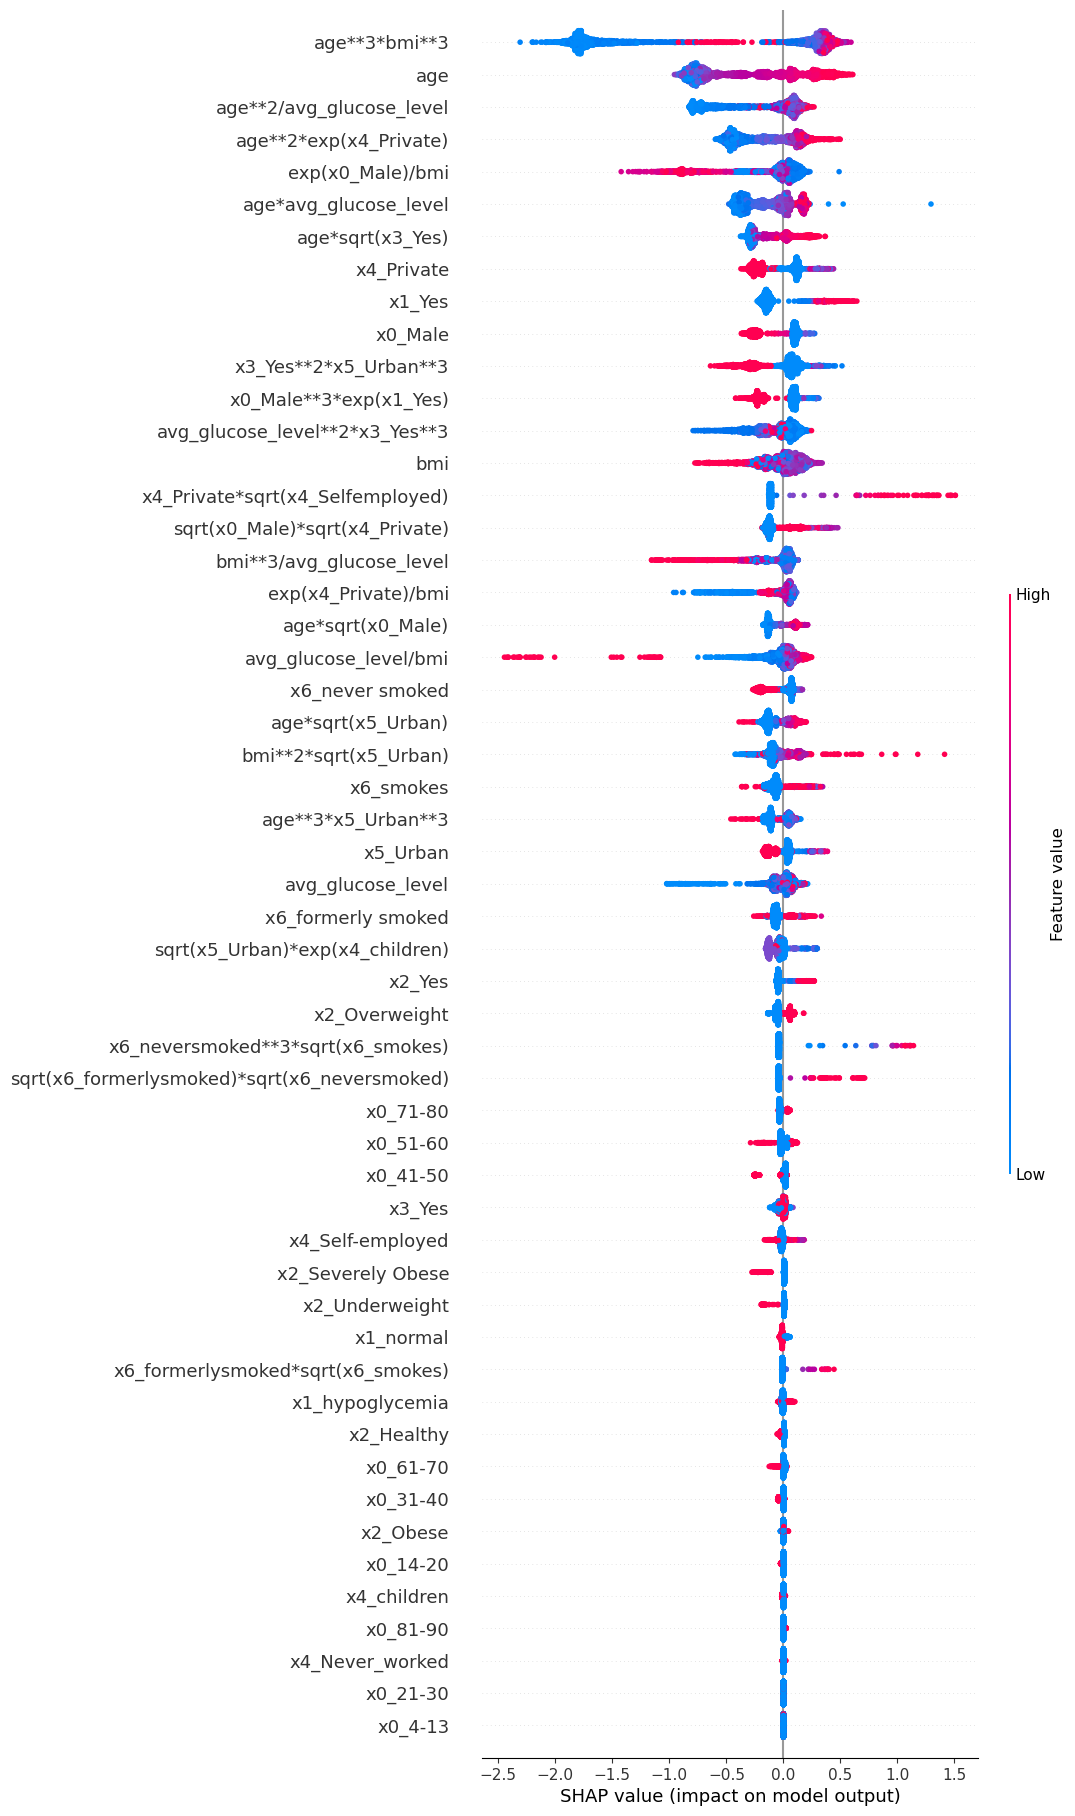

In [103]:
shap_values = shap_viz(
    best_models[2], X_train_sampled_ft_auto, y_train_sampled, kind="tree", scaled=False
)

Catboost does not take many features into account when it's making a prediction. This is essentially problematic, as we don't want unnecessary features to be present in our feature space. This may lead to overfitting. But also keeping those features may not be efficient.

Let's now see how LightGBM reacts to the new features.

In [104]:
cross_val_ft_light_cl_auto = cross_validate_model(
    [best_models[1]], X_train_sampled_ft_auto, y_train=y_train_sampled, pipeline=False
)

In [105]:
cross_val_ft_light_cl_auto.style.background_gradient(cmap="Reds")

LightGBM has a slightly lower score in both recall and precision compared to Catboost.

LGBMClassifier(force_row_wise=True, max_depth=3, random_state=42, reg_alpha=5,
               scale_pos_weight=19.551724137931036, verbosity=-100)


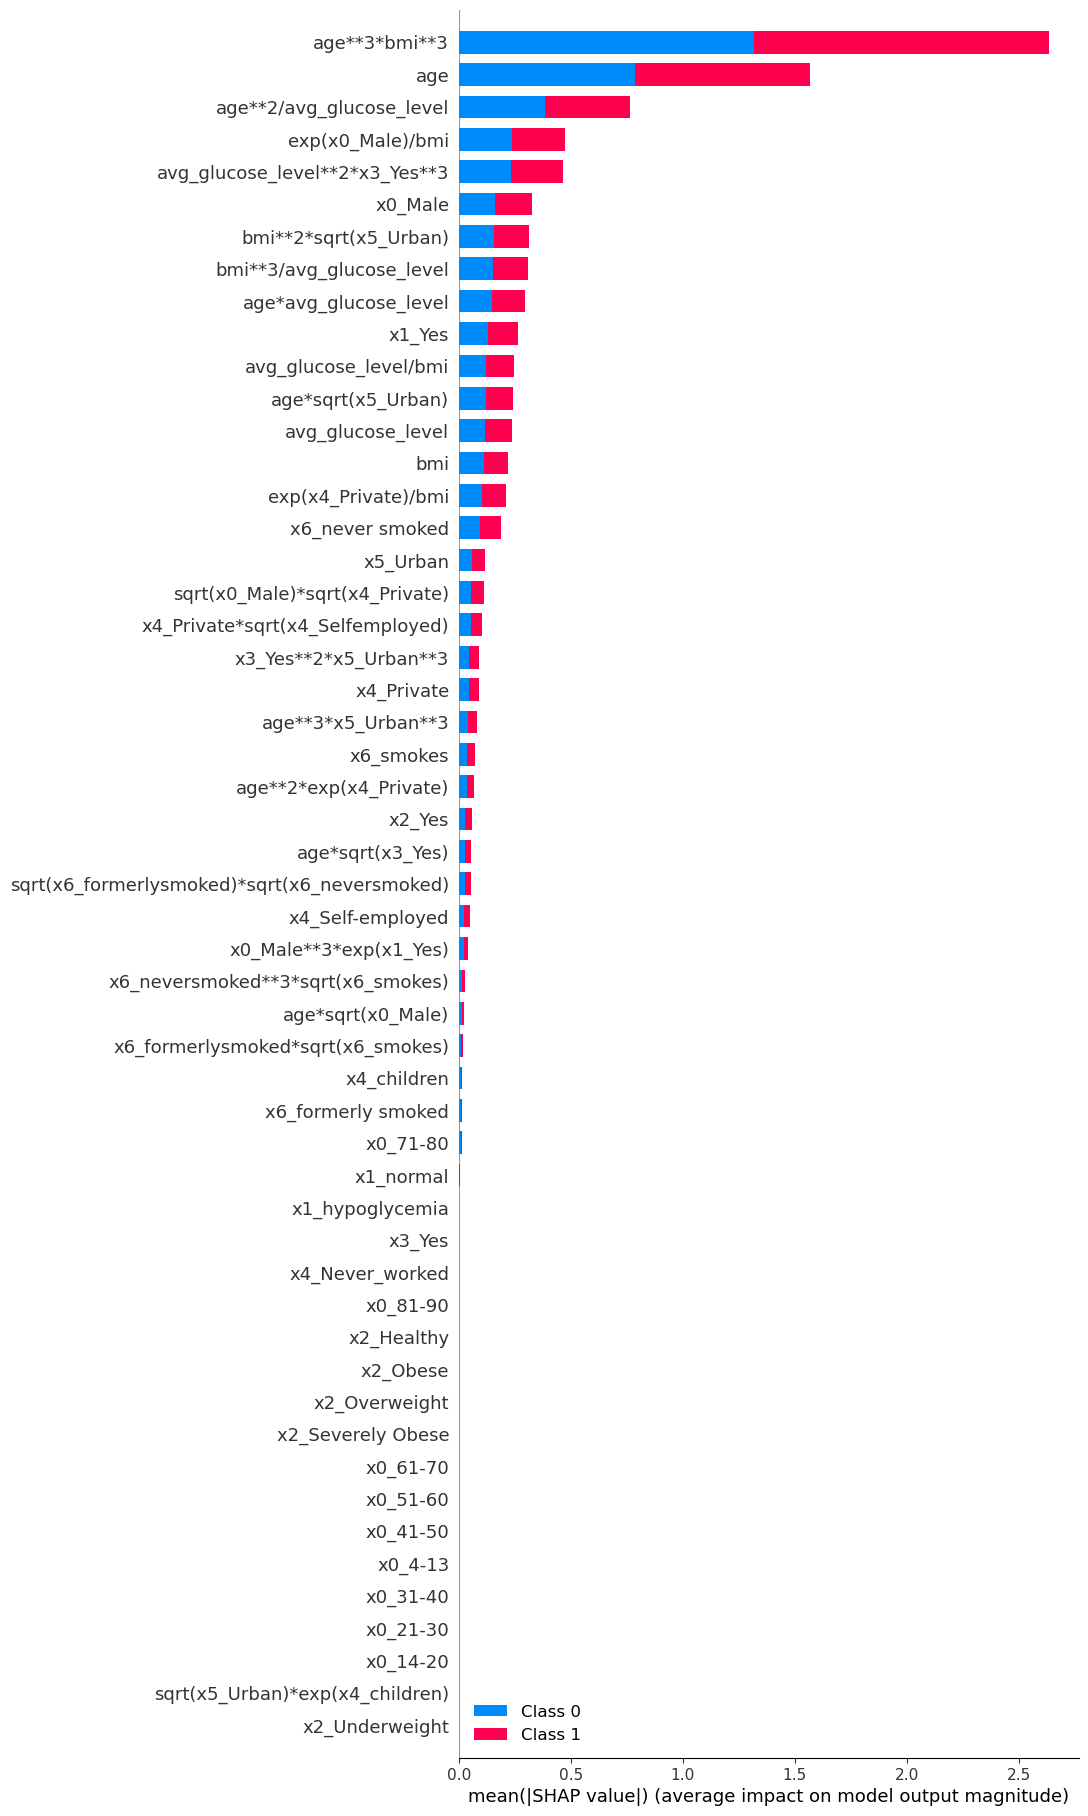

In [106]:
shap_values = shap_viz(
    best_models[1], X_train_sampled_ft_auto, y_train_sampled, kind="tree", scaled=False
)

Shap values show that LightGBM actually does not see most of the features important when making a decision. This model needs feature elimination to be efficient.

In [107]:
cross_val_ft_light_cl_auto.style.background_gradient(cmap="Reds")

### Hyperparameter Tuning & Feature Selection

In this section, we will try to improve the performance by trying different hyperparameters for our model. This may help us find the right regularization for the model. 

In [108]:
cat_search = CatBoostClassifier(
    random_state=42,
    early_stopping_rounds=20,
    scale_pos_weight=pos_weight,
    verbose=False,
)

In [109]:
cat_params = {
    "iterations": np.arange(10, 500, 50),
    "learning_rate": np.linspace(0.01, 0.1, 30),
    "depth": np.arange(2, 6),
    "l2_leaf_reg": np.arange(1, 20, 1),
    "rsm": np.linspace(0.01, 0.5, 50),
    "random_strength": np.arange(0, 15),
}

In [110]:
preprocessor_cat = make_preprocessor(X_train_sampled_ft_auto, scaler=False)


In [111]:
X_train_sampled_cat = preprocessor_cat.fit_transform(X_train_sampled_ft_auto)
X_train_sampled_cat = return_col_names(X_train_sampled_cat, preprocessor_cat)


In [112]:
cat_search.randomized_search(
    param_distributions=cat_params,
    X=X_train_sampled_cat,
    y=y_train_sampled,
    cv=5,
    stratified=True,
    plot=True,
    n_iter=2000,
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3346343653
bestIteration = 159


bestTest = 0.3335056391
bestIteration = 209


bestTest = 0.3045483361
bestIteration = 458


bestTest = 0.466555325
bestIteration = 209


bestTest = 0.5007377967
bestIteration = 309


bestTest = 0.3250329727
bestIteration = 308


bestTest = 0.3468291039
bestIteration = 309


bestTest = 0.6274157996
bestIteration = 9


bestTest = 0.35952933
bestIteration = 159


bestTest = 0.3477753913
bestIteration = 308


bestTest = 0.5832057018
bestIteration = 109


bestTest = 0.4087902158
bestIteration = 209


bestTest = 0.354783389
bestIteration = 159


bestTest = 0.3078489525
bestIteration = 409


bestTest = 0.4036210007
bestIteration = 157


bestTest = 0.3139291067
bestIteration = 448


bestTest = 0.6141552374
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.302061899
bestIteration = 380


bestTest = 0.2940627251
bestIteration = 455


bestTest = 0.4504196723
bestIteration = 107


bestTest = 0.4947340994
bestIterat

{'params': {'random_strength': 6,
  'depth': 4,
  'l2_leaf_reg': 1,
  'iterations': 460,
  'rsm': 0.49,
  'learning_rate': 0.08758620689655172},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
 

In [113]:
cross_val_ft_light_cl_auto_2 = cross_validate_model(
    [cat_search], X_train_sampled_ft_auto, y_train=y_train_sampled, pipeline=False
)
cross_val_ft_light_cl_auto_2.style.background_gradient(cmap="Reds")

After hyperparameter tuning, Catboost seem to improve its precision score but decrease the recall score. Let's try to reduce the number of features to see whether we can improve the score further. 

In [114]:
cat_search.get_params()


{'verbose': False,
 'random_state': 42,
 'scale_pos_weight': 19.551724137931036,
 'early_stopping_rounds': 20,
 'random_strength': 6,
 'depth': 4,
 'l2_leaf_reg': 1,
 'iterations': 460,
 'rsm': 0.49,
 'learning_rate': 0.08758620689655172}

In [115]:
cat_feature_select = [
    CatBoostClassifier(
        verbose=False,
        random_state=42,
        scale_pos_weight=pos_weight,
        early_stopping_rounds=20,
        random_strength=6,
        depth=4,
        l2_leaf_reg=1,
        iterations=460,
        rsm=0.49,
        learning_rate=0.08758620689655172,
    )
]

In [118]:
cat_feature_select[0].fit(X_train_sampled_cat, y_train_sampled)


Minimum test log loss: 4
Maximum test recall: 49
Maximum test precision: 10


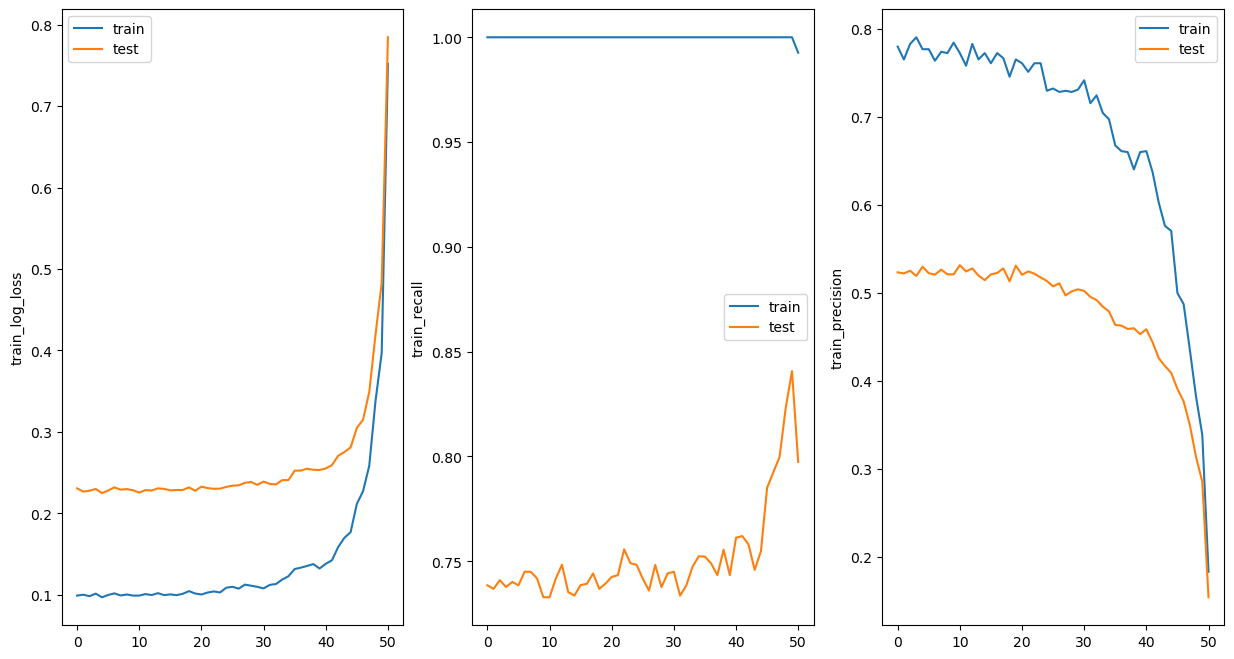

In [119]:
shap_feat_viz_classification(
    cat_feature_select[0], X_train_sampled_cat, y_train_sampled, shap_explainer="tree"
)

Keeping majority of the features seem to be causing the model to overfit to the training set in terms of recall. We want a number of features to keep that won't be causing overfitting, won't have a big drop in precision and log loss. For that reason we chose the number 23. 

After reducing the number of features, we will make another hyperparameter tuning to find the best values that work this new set of features. 

In [120]:
cv, X_train_reduced = shap_feat_reduce_classification(
    cat_feature_select[0], X_train_sampled_cat, y_train_sampled, feats_no=23
)

In [121]:
cv.style.background_gradient(cmap="Reds")

After reducing the number of features, the recall score jumps up to 74 percent, while having a precision of 43 percent. 

In [122]:
cat_search_2 = CatBoostClassifier(
    random_state=42,
    early_stopping_rounds=20,
    scale_pos_weight=pos_weight,
    verbose=False,
)

In [123]:
cat_search_2.randomized_search(
    param_distributions=cat_params,
    X=X_train_reduced,
    y=y_train_sampled,
    cv=5,
    stratified=True,
    plot=True,
    n_iter=2000,
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3693321684
bestIteration = 154


bestTest = 0.3637073648
bestIteration = 209

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3300613066
bestIteration = 401


bestTest = 0.4885655235
bestIteration = 209


bestTest = 0.5274573284
bestIteration = 309

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4874989875
bestIteration = 62


bestTest = 0.3592137406
bestIteration = 299


bestTest = 0.6287515182
bestIteration = 9


bestTest = 0.3848648033
bestIteration = 159


bestTest = 0.3544659278
bestIteration = 309


bestTest = 0.589594373
bestIteration = 109


bestTest = 0.4778870611
bestIteration = 209


bestTest = 0.3695463514
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3399719617
bestIteration = 364


bestTest = 0.4317769376
bestIteration = 159

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3542019485
bestIteration = 284


bestTest = 0.605219744
bestIteration = 9

Stopped b

{'params': {'random_strength': 10,
  'depth': 4,
  'l2_leaf_reg': 19,
  'iterations': 360,
  'rsm': 0.08,
  'learning_rate': 0.0906896551724138},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,


In [124]:
cat_search_2.get_params()


{'verbose': False,
 'random_state': 42,
 'scale_pos_weight': 19.551724137931036,
 'early_stopping_rounds': 20,
 'random_strength': 10,
 'depth': 4,
 'l2_leaf_reg': 19,
 'iterations': 360,
 'rsm': 0.08,
 'learning_rate': 0.0906896551724138}

In [125]:
cross_val_feature_test = cross_validate_model(
    [cat_search_2], X_train_reduced, y_train=y_train_sampled, pipeline=False
)

In [126]:
cross_val_feature_test.style.background_gradient(cmap="Reds")

We were able to boost the recall score while decreasing the precision a bit. Let's now take a look at how the features affect the estimator's decisions.

In [127]:
cat_search_2.fit(X_train_reduced, y_train_sampled)


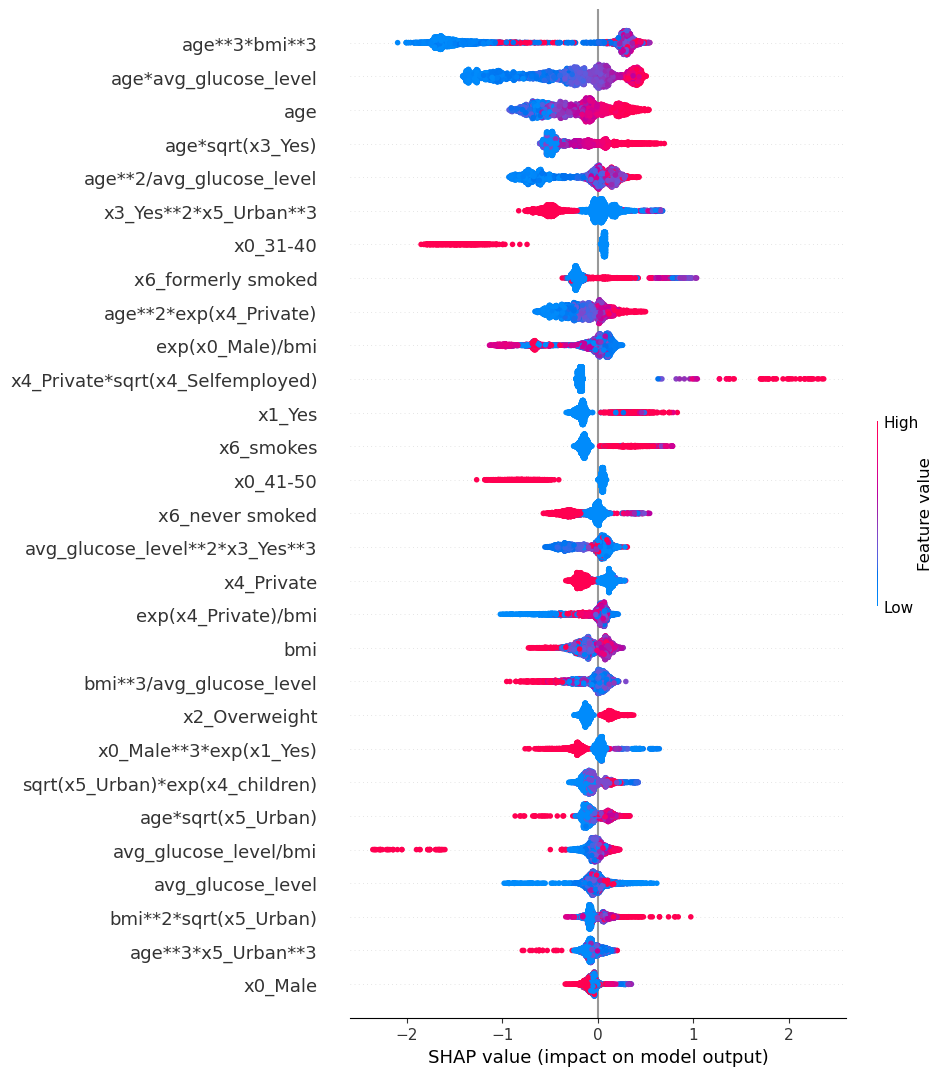

In [128]:
shap_values = shap_viz(
    cat_search_2, X_train_reduced, y_train_sampled, kind="tree", scaled=False
)

We see that the feature that is contributing the most is a combination of age and bmi. In fact, almost all features in our reduced feature space is in a combined form. This includes numerical and categorical combinations. Also age and bmi seem to be contributing on their own.

In [129]:
cat_search_2.save_model("models/stroke_model", format="cbm")

In [130]:
train_preds = cat_search_2.predict(X_train_reduced)


In [131]:
print(classification_report(y_train_sampled, train_preds))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89      3400
           1       0.38      1.00      0.55       408

    accuracy                           0.83      3808
   macro avg       0.69      0.90      0.72      3808
weighted avg       0.93      0.83      0.86      3808



The model is able to detect all the patients with a stroke risk. About 38 percent of all predictions were actually correct. 

<AxesSubplot:>

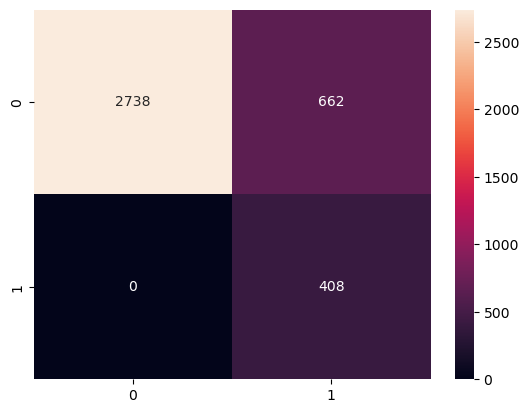

In [132]:
sns.heatmap(confusion_matrix(y_train_sampled, train_preds), annot=True, fmt="g")

Here we see that no individual with stroke risk were missed. But while making these predictions, the model also labeled people without a stroke risk as positive. 

In [133]:
final_cols = X_train_reduced.columns


In [134]:
with open("models/stroke_final_cols", "wb") as stroke_cols:
    pickle.dump(final_cols, stroke_cols)

In [135]:
pickled_preprocessor_1 = open("models/stroke_preprocessor_1", "wb")
pickle.dump(stroke_preprocessor_1, pickled_preprocessor_1)
pickled_preprocessor_1.close()

In [136]:
pickled_preprocessor_2 = open("models/stroke_preprocessor_2", "wb")
pickle.dump(preprocessor_cat, pickled_preprocessor_2)
pickled_preprocessor_2.close()

In [137]:
pickled_autofeat = open("models/stroke_autofeat", "wb")
pickle.dump(auto_features, pickled_autofeat)
pickled_autofeat.close()

In [138]:
X_test_transformed = transformations.stroke_data_transform(X_test)


[AutoFeat] Computing 22 new features.
[AutoFeat]    22/   22 new features ...done.


In [139]:
cat_search_2 = CatBoostClassifier()
cat_search_2.load_model("models/stroke_model")

In [140]:
y_preds = cat_search_2.predict(X_test_transformed)


In [141]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_search_2.classes_)

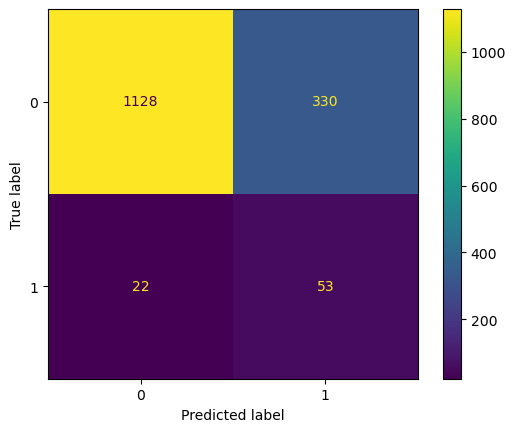

In [142]:
disp.plot()


In [143]:
print(classification_report(y_test, y_preds))


              precision    recall  f1-score   support

           0       0.98      0.77      0.87      1458
           1       0.14      0.71      0.23        75

    accuracy                           0.77      1533
   macro avg       0.56      0.74      0.55      1533
weighted avg       0.94      0.77      0.83      1533



When we test the model on a data that it has not seen before, we see that it is able to detect 71 percent of all individuals with a stroke risk. And out of all the predictions the model has made, 14 percent was actually true. 

In our case, we wanted to identify as many people with a stroke risk as possible. This however, comes with a price. As we increased the model's capacity to catch all people with a risk, it tends to label individuals without a risk with this label. This may be costly, as the false alarms may lead to unnecessary tests. But this is preferable to the opposite case, in which the patients with a stroke risk go undetected.

## Hypertension

In this section, we will be trying to predict individuals with hypertension. In order to predict hypertension, we usually need more information than those provided in this dataset. Usually values related to blood would be helpful in this case. As this dataset lacks this kind of information, the model to be created may suffer from low performance. 

The data regarding to hypertension is also imbalanced. However, the imbalance issue is not as bad as the one with stroke. We will keep the data in its current state. Let's start with simple models to see the initial performance. 

### Simple Models

In [574]:
X = stroke.drop(["stroke", "hypertension"], axis=1)
y = stroke["hypertension"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [575]:
le_hypertension = LabelEncoder()
y_train = le_hypertension.fit_transform(y_train)


In [146]:
model_set_a = [
    LogisticRegression(random_state=42),
    SVC(random_state=42, probability=True),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=2),
]

In [147]:
simple_models = cross_validate_model(
    model_set_a, X_train, y_train, task="classification", scaler=True
)
simple_models.style.background_gradient(cmap="Reds")

As before, simple models without any regularization do not perform well on this dataset. Training scores are much higher than test data and this is a sign of overfitting. Before trying regularization, let's try more complex models.

In [153]:
tree_based = [
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    XGBClassifier(random_state=42, verbose=False),
    LGBMClassifier(random_state=42, verbosity=-100),
    CatBoostClassifier(random_state=42, verbose=False),
]

In [154]:
tree_models = cross_validate_model(tree_based, X_train, y_train, scaler=False)


In [208]:
tree_models.style.background_gradient(cmap="Reds")

More complex models are memorizing the training set more closely, thus resulting in a stronger overfitting. It seems like some regularization will be needed to achieve good performance on this dataset.

In [188]:
model_set_b = [
    LogisticRegression(C=0.5, class_weight="balanced", random_state=1),
    SVC(C=0.5, class_weight="balanced", probability=True, random_state=1),
]

In [189]:
simple_models.style.background_gradient(cmap="Reds")

In [190]:
regularized_models = cross_validate_model(
    model_set_b, X_train, y_train, scaler=True)


In [191]:
regularized_models.style.background_gradient(cmap="Reds")

When some regularization is applied to the models that allow it, there is a dramatic improvement in recall and precision values. Best performing model in this case is SVC which is able to identify 82 percent of all individuals with hypertension. However only 21 percent of these predictions are correct. 

Let's now try regularization on more complex models.

In [155]:
tree_models.style.background_gradient(cmap="Reds")

In [156]:
pos_weight = pd.Series(y_train).value_counts()[
    0] / pd.Series(y_train).value_counts()[1]


In [162]:
tree_based_reg = [
    DecisionTreeClassifier(
        ccp_alpha=0.05, class_weight="balanced", max_depth=3, random_state=42
    ),
    RandomForestClassifier(class_weight="balanced", max_depth=3, random_state=42),
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(class_weight="balanced", max_depth=1),
        learning_rate=0.5,
        random_state=42,
    ),
    GradientBoostingClassifier(learning_rate=0.05, max_depth=5, random_state=42),
    XGBClassifier(
        random_state=42,
        verbosity=0,
        reg_alpha=0.5,
        early_stopping_rounds=15,
        scale_pos_weight=pos_weight,
        max_depth=3,
    ),
    LGBMClassifier(
        random_state=42,
        max_depth=3,
        reg_alpha=5,
        verbosity=-100,
        scale_pos_weight=pos_weight,
        force_row_wise=True,
    ),
    CatBoostClassifier(
        random_state=42,
        l2_leaf_reg=5,
        learning_rate=0.02,
        verbose=False,
        early_stopping_rounds=15,
        scale_pos_weight=pos_weight,
        random_strength=10,
        max_depth=3,
    ),
]

In [160]:
tree_based_reg_cv = cross_validate_model(
    tree_based_reg, X_train, y_train, scaler=False)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [161]:
tree_based_reg_cv.style.background_gradient(cmap="Reds")

Only Decision Tree and Random Forests are able to achieve a similar performance to SVC model. We will be moving forward with these models.

### Feature Engineering

In this section, we will try adding new features to improve the model performance. 

In [576]:
auto_features = Autofeaturetool(X_train, y_train, task="classification")

[AutoFeat] Warning: This just calls fit_transform() but does not return the transformed dataframe.
[AutoFeat] It is much more efficient to call fit_transform() instead of fit() and transform()!
[AutoFeat] The 2 step feature engineering process could generate up to 4851 features.
[AutoFeat] With 4087 data points this new feature matrix would use about 0.08 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 13 transformed features from 14 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 328 feature combinations from 351 original feature tuples - done.
[feateng] Generated altogether 357 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 196 additional features
[featsel] Scaling data...done.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[featsel] Feature selection run 5/5
[featsel] Feature select

In [577]:
with open("models/hypertension_autofeat", "wb") as hyp_auto:
    pickle.dump(auto_features, hyp_auto)

In [578]:
X_train_transformed_2 = auto_features.transform(X_train)


In [196]:
best_models = [
    DecisionTreeClassifier(
        ccp_alpha=0.05, class_weight="balanced", max_depth=3, random_state=42
    ),
    RandomForestClassifier(class_weight="balanced", max_depth=3, random_state=42),
    SVC(C=0.5, class_weight="balanced", probability=True, random_state=1),
]

In [194]:
tree_based_reg_cv_2 = cross_validate_model(
    best_models, X_train_transformed_2, y_train, scaler=False
)

In [176]:
tree_based_reg_cv_2_svc = cross_validate_model(
    [best_models[-1]], X_train_transformed_2, y_train, scaler=True
)

In [195]:
tree_based_reg_cv.style.background_gradient(cmap="Reds")

In [171]:
tree_based_reg_cv_2.style.background_gradient(cmap="Reds")

In [192]:
regularized_models.style.background_gradient(cmap="Reds")

In [177]:
tree_based_reg_cv_2_svc.style.background_gradient(cmap="Reds")

In all cases, adding the automatically generated features did not lead to an improvement. We will not be adding these new features to our feature space. Let's now try creating our own features.

In [579]:
X_train_transformed_3 = add_features(X_train)


In [198]:
tree_based_reg_cv_3 = cross_validate_model(
    best_models, X_train_transformed_3, y_train, scaler=False
)

In [197]:
tree_based_reg_cv_3_svc = cross_validate_model(
    [best_models[-1]], X_train_transformed_3, y_train, scaler=True
)

In [199]:
tree_based_reg_cv_3.style.background_gradient(cmap="Reds")

In [200]:
tree_based_reg_cv_3_svc.style.background_gradient(cmap="Reds")

This feature engineering step also did not result in any change in models. In fact it caused the SVC model to perform worse. We will try to improve our model by searching good hyperparameters and feature selection. 

### Hyperparameter Tuning & Feature Selection

In [208]:
best_models


[DecisionTreeClassifier(ccp_alpha=0.05, class_weight='balanced', max_depth=3,
                        random_state=42),
 RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=42),
 SVC(C=0.5, class_weight='balanced', probability=True, random_state=1)]

In [359]:
final_model = SVC(class_weight="balanced", probability=True, random_state=42)

In [361]:
svc_params = {
    "C": np.linspace(0.1, 1, 10),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": np.arange(1, 4),
    "gamma": ["scale", "auto"],
}

In [582]:
preprocessor = make_preprocessor(X_train, scaler=True)
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed = return_col_names(X_train_transformed, preprocessor)


In [364]:
randomized_cv = randomized_tuning(
    final_model,
    X_train=X_train_transformed,
    y_train=y_train,
    n_iters=200,
    task="classification",
    pipeline=False,
    scaled=False,
    params=svc_params,
)

In [365]:
pd.set_option("display.max_columns", None)


In [366]:
randomized_cv.sort_values(["mean_test_roc_auc"], ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
159       1.730474      0.028527         0.060945        0.007514   
53        1.963365      0.103369         0.062204        0.014690   
118       3.009370      0.158544         0.217659        0.029457   
25        2.720509      0.154826         0.185083        0.019588   
186       2.491144      0.294920         0.190192        0.061720   
..             ...           ...              ...             ...   
173       1.897447      0.092350         0.072504        0.016813   
190       1.523897      0.080058         0.048367        0.007111   
40        1.960248      0.089043         0.070592        0.009772   
57        1.926735      0.095102         0.072411        0.025016   
22        1.818214      0.153359         0.057013        0.007920   

    param_kernel param_gamma param_degree param_C  \
159         poly       scale            1     0.7   
53          poly       scale            1     0.9   
118          rbf        auto            2     0.7   
25           rbf        auto            1     0.7   
186          rbf        auto            3     0.7   
..           ...         ...          ...     ...   
173      sigmoid       scale            1     0.8   
190      sigmoid       scale            1     0.9   
40       sigmoid       scale            2     1.0   
57       sigmoid       scale            1     1.0   
22       sigmoid       scale            3     1.0   

                                                params  split0_test_accuracy  \
159  {'kernel': 'poly', 'gamma': 'scale', 'degree':...              0.667482   
53   {'kernel': 'poly', 'gamma': 'scale', 'degree':...              0.667482   
118  {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2...              0.643032   
25   {'kernel': 'rbf', 'gamma': 'auto', 'degree': 1...              0.643032   
186  {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3...              0.643032   
..                                                 ...                   ...   
173  {'kernel': 'sigmoid', 'gamma': 'scale', 'degre...              0.630807   
190  {'kernel': 'sigmoid', 'gamma': 'scale', 'degre...              0.630807   
40   {'kernel': 'sigmoid', 'gamma': 'scale', 'degre...              0.630807   
57   {'kernel': 'sigmoid', 'gamma': 'scale', 'degre...              0.630807   
22   {'kernel': 'sigmoid', 'gamma': 'scale', 'degre...              0.630807   

     split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
159              0.652812              0.662592              0.684597   
53               0.652812              0.667482              0.684597   
118              0.635697              0.645477              0.682152   
25               0.635697              0.645477              0.682152   
186              0.635697              0.645477              0.682152   
..                    ...                   ...                   ...   
173              0.608802              0.635697              0.618582   
190              0.596577              0.635697              0.618582   
40               0.601467              0.635697              0.616137   
57               0.601467              0.635697              0.616137   
22               0.601467              0.635697              0.616137   

     split4_test_accuracy  split5_test_accuracy  split6_test_accuracy  \
159              0.645477              0.691932              0.716381   
53               0.643032              0.691932              0.716381   
118              0.628362              0.674817              0.699267   
25               0.628362              0.674817              0.699267   
186              0.628362              0.674817              0.699267   
..                    ...                   ...                   ...   
173              0.599022              0.665037              0.643032   
190              0.596577              0.665037              0.643032   
40               0.599022              0.662

The best model returns a recall score of 89 percent, which outperforms all the values we have seen so far. We will be moving on with this model. 

In [367]:
randomized_cv.sort_values(
    ["mean_test_recall", "mean_test_precision"], ascending=False
).loc[159, "params"]

{'kernel': 'poly', 'gamma': 'scale', 'degree': 1, 'C': 0.7000000000000001}

In [583]:
final_model = SVC(
    class_weight="balanced",
    probability=True,
    random_state=42,
    kernel="poly",
    gamma="scale",
    degree=1,
    C=0.7,
)

In [584]:
tree_based_reg_cv_4 = cross_validate_model(
    [final_model], X_train_transformed, y_train, scaler=False
)

In [585]:
tree_based_reg_cv_4.style.background_gradient(cmap="Reds")

We see a similar performance in the cross validation. 

In [586]:
with open("models/hypertension_preprocessor_2", "wb") as hypertension_pre_loc_1:
    joblib.dump(preprocessor, hypertension_pre_loc_1)

In [587]:
final_model.fit(X_train_transformed, y_train)


SVC(C=0.7, class_weight='balanced', degree=1, kernel='poly', probability=True,
    random_state=42)

In [388]:
y_train_pred = final_model.predict(X_train_transformed)


In [389]:
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

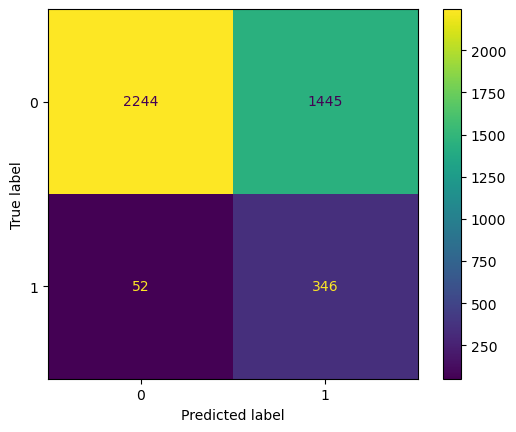

In [390]:
disp.plot()


The classifier was able to detect most of the positive class correctly. It identified 346 individuals with hypertension correctly, while missing 52 individuals. However, while doing so, it labelled 1445 individuals with a hypertension condition incorrectly. 

In [391]:
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.98      0.61      0.75      3689
           1       0.19      0.87      0.32       398

    accuracy                           0.63      4087
   macro avg       0.59      0.74      0.53      4087
weighted avg       0.90      0.63      0.71      4087



The metrics show us that this model was able to detect 87 percent of all individuals with hypertension. However, only 19 percent of all predictions were correct. As we don't want any person with hypertension to go undetected, this model is doing a good job at this area. However, as it also incorrectly labels many people with hypertension, the model may cause unnecessary costs.

In [405]:
X_test_final = preprocessor.transform(X_test)


In [406]:
X_test_final = return_col_names(X_test_final, preprocessor)


In [408]:
y_test_final = le_hypertension.transform(y_test)


In [409]:
y_pred = final_model.predict(X_test_final)


In [412]:
cm = confusion_matrix(y_test_final, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

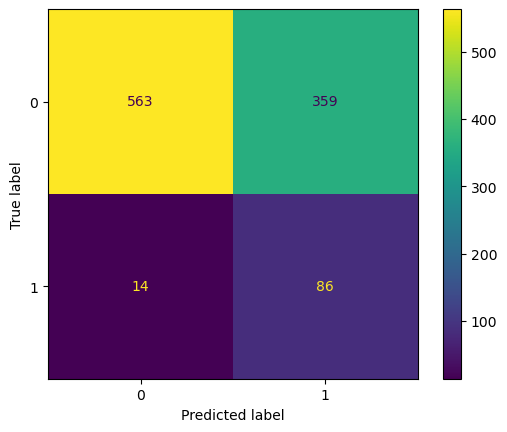

In [413]:
disp.plot()


In [414]:
print(classification_report(y_test_final, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.61      0.75       922
           1       0.19      0.86      0.32       100

    accuracy                           0.64      1022
   macro avg       0.58      0.74      0.53      1022
weighted avg       0.90      0.64      0.71      1022



The metrics on the test set are close to what we have seen on the training set. The model is able to detect 86 percent of all individuals with a hypertension problem. Meanwhile, only 19 percent of all predictions were true. As mentioned before, it is preferable to make errors while being able to detect most people with hypertension, rather than having people with this condition go undetected. The downside of this approach may be higher costs. However, this is also preferable to the outcomes of the opposite situation.

In [588]:
with open("hypertension_model.sav", "wb") as svc_final:
    joblib.dump(final_model, svc_final)

## Glucose Level Predictor

In this section, we will use the same data to predict a patient's average glucose levels. In this case also, the data may not be sufficient enough for our model to understand the reasons for a certain glucose level. For starters, we will initiate some simple models.

### Simple Models

In [419]:
X = stroke.drop(["stroke", "avg_glucose_level"], axis=1)
y = stroke["avg_glucose_level"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [420]:
simple_models = [LinearRegression(), SVR(), ElasticNet(), SGDRegressor()]

In [421]:
cv_1 = cross_validate_model(
    simple_models, X_train, y_train, task="regression", scaler=True
)
cv_1.style.background_gradient(cmap="Reds")

With simple models, the lowest error the model is making is around 43 mg. This value is very high for a glucose predictor, as such a change in glucose could change a patient's health condition dramatically. Also very low r2 scores in all cases show us that none of the models find the features enough to explain the variance in the dataset. 

Let's now try some tree based model to see whether they are able to make better predictions.

In [423]:
tree_models = [
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42, verbose=False),
    LGBMRegressor(random_state=42, verbosity=-100),
    CatBoostRegressor(random_state=42, verbose=False),
]

In [424]:
cv_2 = cross_validate_model(
    tree_models, X_train, y_train, task="regression", scaler=False
)
cv_2.style.background_gradient(cmap="Reds")

In [ ]:
cv_1.style.background_gradient(cmap="Reds")

In all cases, tree based models performed worse compared to the simple models we have checked. There is also a possiblity that these models are overfitting to the data. Next, we will try penalizing the models to see whether that will lead to an improvement.

In [425]:
simple_models_2 = [
    LinearRegression(),
    SVR(C=0.5),
    ElasticNet(alpha=0.5),
    SGDRegressor(penalty="elasticnet", l1_ratio=0.5),
]

In [426]:
cv_3 = cross_validate_model(
    simple_models_2, X_train, y_train, task="regression", scaler=True
)

In [427]:
cv_3.style.background_gradient(cmap="Reds")

Regularization improved some of the models. However, scores are still underwhelming. Let's now try this step for tree based models.

In [430]:
tree_models_2 = [
    DecisionTreeRegressor(random_state=42, max_depth=3),
    RandomForestRegressor(random_state=42, max_depth=3),
    GradientBoostingRegressor(random_state=42, max_depth=3),
    XGBRegressor(random_state=42, max_depth=3, verbose=False),
    LGBMRegressor(random_state=42, max_depth=3, verbosity=-100),
    CatBoostRegressor(random_state=42, max_depth=3, verbose=False),
]

In [431]:
cv_4 = cross_validate_model(
    tree_models_2, X_train, y_train, task="regression", scaler=False
)

In [432]:
cv_2.style.background_gradient(cmap="Reds")

In [ ]:
cv_4.style.background_gradient(cmap="Reds")

Regularization made tree based models much less prone to overfitting. This in turn improved the scores we see on the test data. The best performing model here is LightGBM, which made an error of 43 percent, which is close to the levels we see with simple models.

### Feature Engineering

In this section, we will try to add new features to feed more information to models. We hope to improve the model performance by doing so. 

In [433]:
auto_features_tool = Autofeaturetool(task="regression", data_x=X_train, data_y=y_train)

[AutoFeat] Warning: This just calls fit_transform() but does not return the transformed dataframe.
[AutoFeat] It is much more efficient to call fit_transform() instead of fit() and transform()!
[AutoFeat] The 2 step feature engineering process could generate up to 4851 features.
[AutoFeat] With 4087 data points this new feature matrix would use about 0.08 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 8 transformed features from 14 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 210 feature combinations from 231 original feature tuples - done.
[feateng] Generated altogether 236 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 132 additional features
[featsel] Scaling data...done.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[featsel] Feature selection run 2/5
[featsel] Feature selecti

In [434]:
with open("models/glucose_autofeat", "wb") as glucose_autofeat:
    pickle.dump(auto_features_tool, glucose_autofeat)

In [435]:
X_train_transformed = auto_features_tool.transform(X_train)


[AutoFeat] Computing 6 new features.
[AutoFeat]     6/    6 new features ...done.


In [436]:
cv_3.style.background_gradient(cmap="Reds")

In [437]:
cv_5 = cross_validate_model(
    simple_models_2, X_train_transformed, y_train, task="regression"
)

In [438]:
cv_5.style.background_gradient(cmap="Reds")

New features improved the performance of the models by little. This performance increase confirms our suspicion that the models are lacking vital information to understand glucose levels. Let's do this step again for tree based models.

In [439]:
cv_4.style.background_gradient(cmap="Reds")

In [440]:
cv_6 = cross_validate_model(
    tree_models_2, X_train_transformed, y_train, task="regression", scaler=False
)

In [441]:
cv_6.style.background_gradient(cmap="Reds")

While some models had their performance increased when trained with new features, other had a decrease. The best performing model here is Random Forests. However, even the best performing tree based model is not able to pass ElasticNet in performance.

In [443]:
cv_5.style.background_gradient(cmap="Reds")

Now, we will add more features to the training set to improve the performance.

In [444]:
X_train_transformed_2 = add_features(X_train_transformed, exclude="glucose")

In [445]:
cv_7 = cross_validate_model(
    simple_models_2, X_train_transformed_2, y_train, task="regression", scaler=True
)

In [446]:
cv_7.style.background_gradient(cmap="Reds")

New features improved the model performance slightly. ElasticNet is still the best performing model. 

In [447]:
cv_8 = cross_validate_model(
    tree_models_2, X_train_transformed_2, y_train, task="regression", scaler=False
)

In [448]:
cv_8.style.background_gradient(cmap="Reds")

In [449]:
cv_6.style.background_gradient(cmap="Reds")

For tree based models, LightGBM is still giving the best performance, and it had a small improvement with new features.

### Hyperparameter Tuning & Feature Selection

In order to further increase our model performance, we will run a hyperparameter tuning step on the best performing model. 

In [450]:
best_models = [ElasticNet(alpha=0.5, random_state=42)]


In [453]:
param_grid_elastic = {
    "classifier__alpha": np.linspace(0, 1, 20),
    "classifier__l1_ratio": np.linspace(0, 1, 20),
    "classifier__max_iter": np.arange(500, 2100, 100),
}

In [ ]:
elastic_tune = randomized_tuning(
    best_models[0],
    params=param_grid_elastic,
    X_train=X_train_transformed_2,
    y_train=y_train,
    n_iters=500,
    task="regression",
    scaled=True,
)

In [455]:
elastic_tune.sort_values("rank_test_neg_mean_squared_error")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
175       0.020690      0.008614         0.004223        0.002241   
446       0.025012      0.011580         0.006356        0.002445   
303       0.029920      0.016934         0.012869        0.018243   
294       0.018235      0.006215         0.008316        0.005219   
66        0.022137      0.007021         0.005118        0.002015   
..             ...           ...              ...             ...   
54        0.021511      0.006103         0.005478        0.002723   
234       0.032093      0.010292         0.012862        0.008617   
220       0.022744      0.003947         0.004758        0.001845   
208       0.041445      0.022191         0.015725        0.012795   
445       0.036014      0.012197         0.005693        0.002886   

    param_classifier__max_iter param_classifier__l1_ratio  \
175                        500                   0.631579   
446                       1200                   0.631579   
303                       1900                   0.684211   
294                        700                   0.578947   
66                        1900                   0.578947   
..                         ...                        ...   
54                        1100                   0.684211   
234                       1400                   0.842105   
220                       1700                   0.894737   
208                        800                   0.947368   
445                       1900                   0.947368   

    param_classifier__alpha  \
175                0.315789   
446                0.315789   
303                0.315789   
294                0.315789   
66                 0.315789   
..                      ...   
54                 0.052632   
234                0.052632   
220                0.052632   
208                0.052632   
445                0.052632   

                                                params  \
175  {'classifier__max_iter': 500, 'classifier__l1_...   
446  {'classifier__max_iter': 1200, 'classifier__l1...   
303  {'classifier__max_iter': 1900, 'classifier__l1...   
294  {'classifier__max_iter': 700, 'classifier__l1_...   
66   {'classifier__max_iter': 1900, 'classifier__l1...   
..                                                 ...   
54   {'classifier__max_iter': 1100, 'classifier__l1...   
234  {'classifier__max_iter': 1400, 'classifier__l1...   
220  {'classifier__max_iter': 1700, 'classifier__l1...   
208  {'classifier__max_iter': 800, 'classifier__l1_...   
445  {'classifier__max_iter': 1900, 'classifier__l1...   

     split0_test_neg_mean_squared_error  split1_test_neg_mean_squared_error  \
175                        -2166.719738                        -1892.900974   
446                        -2166.719738                        -1892.900974   
303                        -2166.251462                        -1893.857779   
294                        -2167.399215                        -1892.101161   
66                         -2167.399215                        -1892.101161   
..                                  ...                                 ...   
54                         -2144.639884                        -1910.810225   
234                        -2142.721625                        -1912.824820   
220                        -2141.890021                        -1913.451806   
208                        -2140.835024                        -1914.059478   
445                        -2140.835024                        -1914.059478   

     split2_test_neg_mean_squared_error  split3_test_neg_mean_squared_error  \
175                        -1714.915709                        -1869.296550   
446                        -1714.915709                        -1869.296550   
303                        -1715.436843                        -1869.070283   
294                        -1714.462728                        -1869.565786   
66                         -1

The model with best hyperparameters makes an error around 42.6, which is close to what we have seen before. Let's fit this model once again and check shap values.

In [456]:
elastic_hyperparameters = list(
    elastic_tune.sort_values("rank_test_neg_mean_squared_error").head(1)["params"]
)[0]

In [457]:
elastic_hyperparameters


{'classifier__max_iter': 500,
 'classifier__l1_ratio': 0.631578947368421,
 'classifier__alpha': 0.3157894736842105}

In [458]:
elastic_max_iter = elastic_hyperparameters["classifier__max_iter"]
elastic_l1_ratio = elastic_hyperparameters["classifier__l1_ratio"]
elastic_alpha = elastic_hyperparameters["classifier__alpha"]

In [459]:
final_model = ElasticNet(
    random_state=42,
    max_iter=elastic_max_iter,
    l1_ratio=elastic_l1_ratio,
    alpha=elastic_alpha,
)

In [460]:
preprocessor_final_glucose = make_preprocessor(X_train_transformed_2)


In [461]:
X_train_final_glucose = preprocessor_final_glucose.fit_transform(X_train_transformed_2)
X_train_final_glucose = return_col_names(
    X_train_final_glucose, preprocessor_final_glucose
)

In [462]:
with open("models/glucose_preprocessor_2", "wb") as glu_preprocess:
    pickle.dump(preprocessor_final_glucose, glu_preprocess)

ElasticNet(alpha=0.3157894736842105, l1_ratio=0.631578947368421, max_iter=500,
           random_state=42)


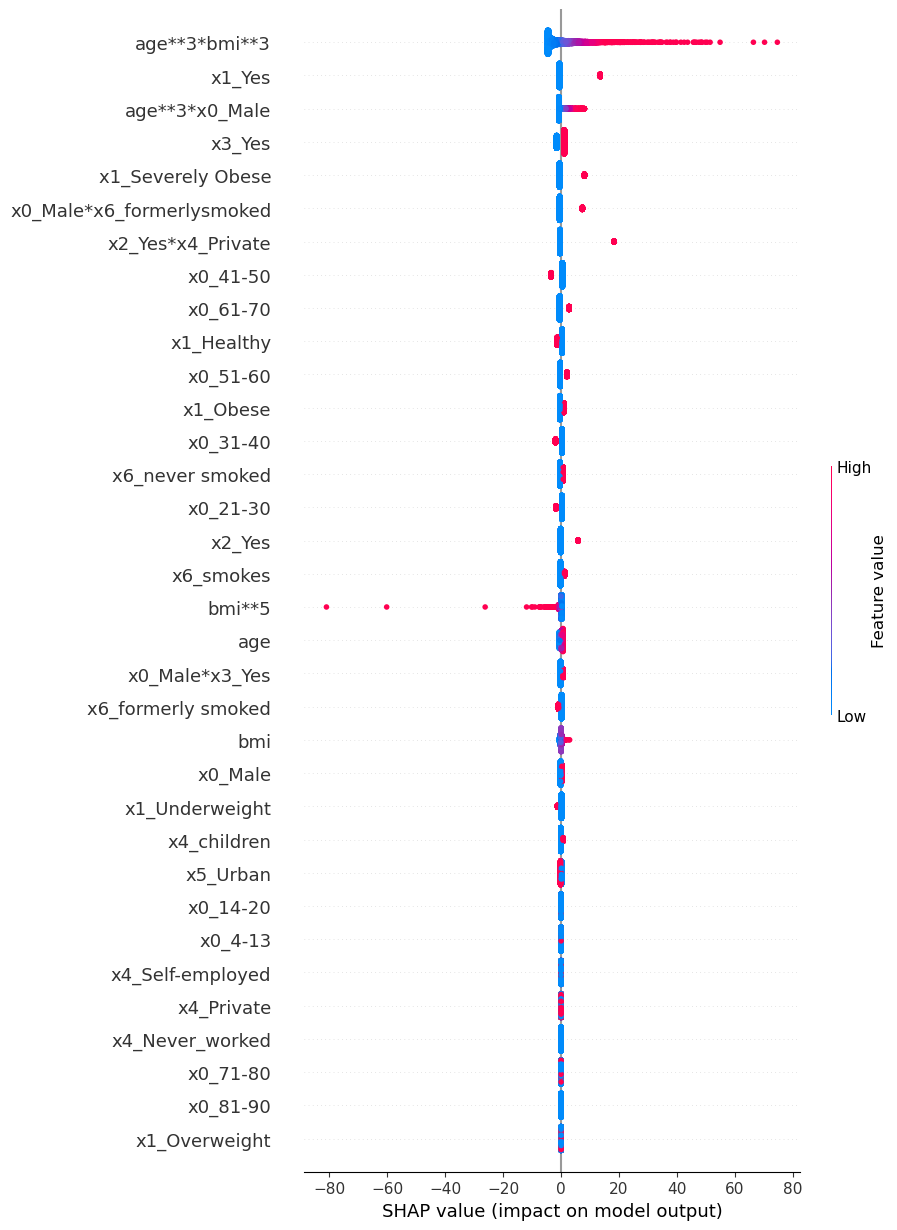

In [463]:
shap_values = shap_viz(
    final_model, X_train_final_glucose, y_train, kind="linear", scaled=True
)

It looks like the model was actually not giving any importance to most features. At this step, feature reduction would be a sensible step to perform. Let's see how many feature reduction steps gives the best performance.

Minimum test mse: 13
Minimum test rmse: 13
Maximum test r2: 13


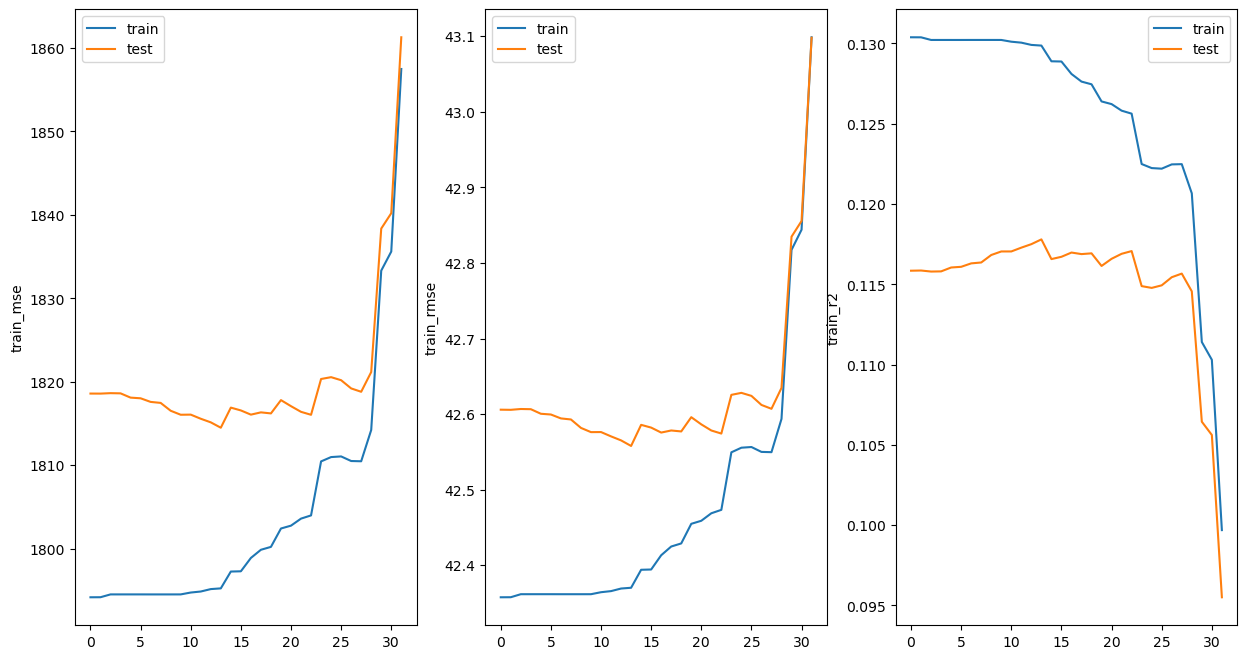

In [464]:
shap_feat_viz_regression(final_model, X_train_final_glucose, y_train, "linear")

After dropping 13 features, the model reaches its peak performance. Let's drop those features in this order to see whether that improves the performance.

In [467]:
cross_val_df, X_train_reduced = shap_feat_reduce_regression(
    final_model, X_train_final_glucose, y_train, 13
)

In [468]:
cross_val_df.style.background_gradient(cmap="Reds")

The mean error the model makes is slightly lower than what we have seen on the hyperparameter tuning step. We will be moving on with this model.

In [469]:
final_model.fit(X_train_reduced, y_train)


ElasticNet(alpha=0.3157894736842105, l1_ratio=0.631578947368421, max_iter=500,
           random_state=42)

In [472]:
filename = "models/glucose_model.sav"
joblib.dump(final_model, filename)

['models/glucose_model.sav']

ElasticNet(alpha=0.3157894736842105, l1_ratio=0.631578947368421, max_iter=500,
           random_state=42)


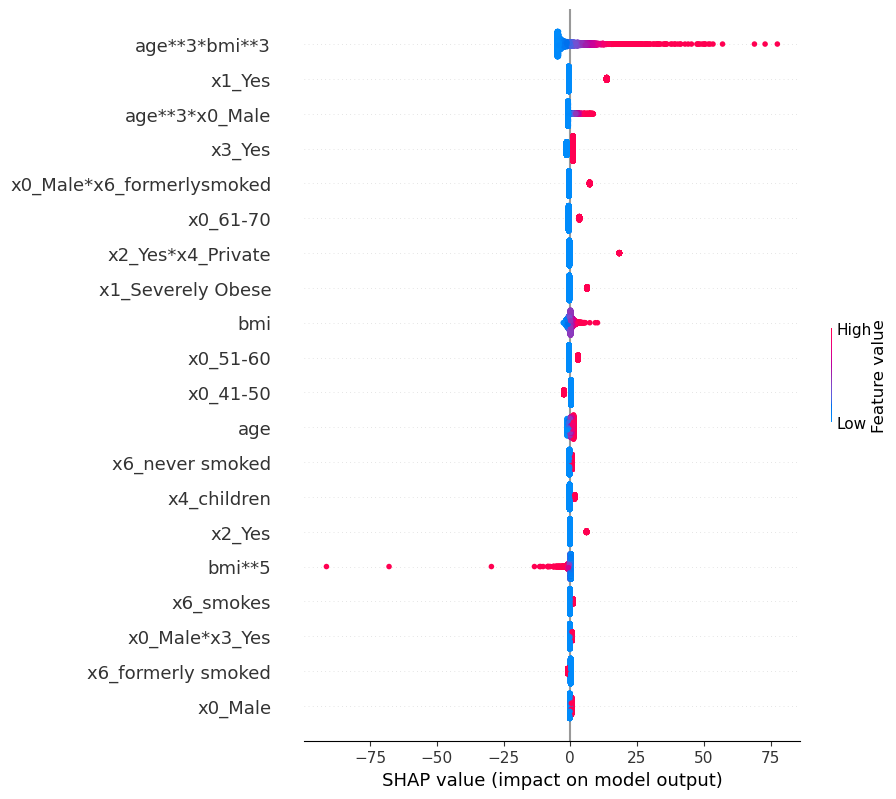

In [473]:
shap_values = shap_viz(
    final_model, X_train_reduced, y_train, kind="linear", scaled=True
)

We now see that all features have some effect on the model's decisions. However some features are less important than the others. The largest impact seem to be coming from a combination of age and bmi features. 

In [474]:
y_train_pred = final_model.predict(X_train_reduced)


In [475]:
mean_squared_error(y_pred=y_train_pred, y_true=y_train)


1801.495817347104

In [476]:
mean_squared_error(y_pred=y_train_pred, y_true=y_train, squared=False)


42.444031586868654

The model is making an error of 42.4 when predicting the training set. This error is unfortunately very large, considering average glucose levels. An error of this magnitude is too large, as a difference around this value in blood could be a sign of a serious health issue. 

In [477]:
r2_score(y_pred=y_train_pred, y_true=y_train)


0.12683001111426162

The model does not necessarily describe the variance in the data.

In [478]:
X_test_transformed = auto_features_tool.transform(X_test)


[AutoFeat] Computing 6 new features.
[AutoFeat]     6/    6 new features ...done.


In [479]:
X_test_transformed = add_features(X_test_transformed, exclude="glucose")

In [480]:
X_test_transformed = preprocessor_final_glucose.transform(X_test_transformed)


In [481]:
X_test_transformed = return_col_names(
    X_test_transformed, preprocessor_final_glucose)


In [482]:
final_cols_glucose = X_train_reduced.columns


In [483]:
with open("models/glucose_final_cols", "wb") as glu_cols:
    pickle.dump(final_cols_glucose, glu_cols)

In [484]:
X_test_transformed = X_test_transformed[final_cols_glucose]


In [485]:
y_pred = final_model.predict(X_test_transformed)


In [486]:
mean_squared_error(y_pred=y_pred, y_true=y_test)


1834.7705295275766

In [487]:
mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)


42.83422147684695

The error on the test data is not too different from the one we have seen on the training data. However, as mentioned before this error is too high to be used in a real world setting.

In [488]:
r2_score(y_pred=y_pred, y_true=y_test)


0.08215015139122683

## BMI Prediction Model

BMI of a person is usually related to lifestyle choices. However, in this dataset, the data we have is related to an individual's health issues. Let's see how our model can predict training on this data.

### Simple Models

In [491]:
bmi = stroke.dropna()
X = bmi.drop(["stroke", "bmi"], axis=1)
y = bmi["bmi"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [493]:
auto_features = Autofeaturetool(X_train, y_train, task="regression")
X_train_transformed_2 = auto_features.transform(X_train)
X_train_transformed_3 = add_features(X_train_transformed_2, exclude="bmi")

[AutoFeat] Warning: This just calls fit_transform() but does not return the transformed dataframe.
[AutoFeat] It is much more efficient to call fit_transform() instead of fit() and transform()!
[AutoFeat] The 2 step feature engineering process could generate up to 4851 features.
[AutoFeat] With 3926 data points this new feature matrix would use about 0.08 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 8 transformed features from 14 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 209 feature combinations from 231 original feature tuples - done.
[feateng] Generated altogether 236 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 146 additional features
[featsel] Scaling data...done.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[featsel] Feature selection run 3/5
[featsel] Feature selecti

In [494]:
with open("models/bmi_autofeat", "wb") as bmi_auto:
    pickle.dump(auto_features, bmi_auto)

In [495]:
simple_models = [LinearRegression(), SVR(), ElasticNet(), SGDRegressor()]


In [496]:
cv_1 = cross_validate_model(simple_models, X_train, y_train, task="regression")
cv_1.style.background_gradient(cmap="Reds")

Our best model is making an error of 6.8. This value is too high considering BMI values. Usually an increase around 5 could change a person's status from normal weight to obesity. Let's try more complex models to see whether they can understand the data better.

In [498]:
tree_based = [
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42, verbose=False),
    LGBMRegressor(random_state=42, verbosity=-100),
    CatBoostRegressor(random_state=42, verbose=False),
]

In [499]:
cv_2 = cross_validate_model(
    tree_based, X_train, y_train, task="regression", scaler=False
)
cv_2.style.background_gradient(cmap="Reds")

Gradient boosting is the best performing model here and it's making less error than the best performing simple model.

In [500]:
simple_models_2 = [
    LinearRegression(),
    SVR(C=0.5),
    ElasticNet(alpha=0.5),
    SGDRegressor(l1_ratio=0.5, penalty="elasticnet"),
]

Let's now try some regularization to see whether this step may increase the model performance.

In [501]:
cv_3 = cross_validate_model(simple_models_2, X_train, y_train, task="regression")
cv_3.style.background_gradient(cmap="Reds")

In [502]:
cv_1.style.background_gradient(cmap="Reds")

Regularization caused the model to make slightly higher errors.

In [504]:
tree_models_2 = [
    DecisionTreeRegressor(max_depth=3, random_state=42),
    RandomForestRegressor(max_depth=3, random_state=42),
    GradientBoostingRegressor(max_depth=3, random_state=42),
    XGBRegressor(max_depth=3, random_state=42, verbose=False),
    CatBoostRegressor(max_depth=3, random_state=42, verbose=False),
]

In [505]:
cv_4 = cross_validate_model(
    tree_models_2, X_train, y_train, task="regression", scaler=False
)

In [ ]:
cv_4.style.background_gradient(cmap="Reds")

In [ ]:
cv_2.style.background_gradient(cmap="Reds")

Regularization helped RandomForests to achieve the best error we have seen so far. However, the improvement is very small.

We will now try to add automatically generated features to the model to increase the performance.

In [506]:
cv_5 = cross_validate_model(
    simple_models_2, X_train_transformed_2, y_train, task="regression"
)

In [507]:
cv_5.style.background_gradient(cmap="Reds")

Adding new features increased some of the models' performances. The performance increase is highest in linear regression, which achieved the best score we have seen so far.

In [508]:
cv_3.style.background_gradient(cmap="Reds")

We will add more features to the model in this stage to test for a performance increase.

In [509]:
cv_6 = cross_validate_model(
    simple_models_2, X_train_transformed_3, y_train, task="regression"
)

In [510]:
cv_6.style.background_gradient(cmap="Reds")

In [511]:
cv_5.style.background_gradient(cmap="Reds")

Linear Regression was able to benefit from the new information we have added to the model.

In [ ]:
cv_7.style.background_gradient(cmap="Reds")

In [ ]:
cv_8 = cross_validate_model(
    tree_models_2, X_train_transformed_2, y_train, task="regression", scaler=False
)

In [ ]:
cv_8.style.background_gradient(cmap="Reds")

In [ ]:
cv_4.style.background_gradient(cmap="Reds")

In [ ]:
cv_9 = cross_validate_model(
    tree_models_2, X_train_transformed_3, y_train, task="regression", scaler=False
)

In [ ]:
cv_9.style.background_gradient(cmap="Reds")

In [ ]:
cv_4.style.background_gradient(cmap="Reds")

Adding new features do not help tree models to achieve a comparable score to Linear Regression. We will be moving on with Linear Regression.

In [512]:
best_model_bmi = LinearRegression()


In [513]:
bmi_final_preprocessor = make_preprocessor(X_train_transformed_2)


In [514]:
X_train_transformed_2 = bmi_final_preprocessor.fit_transform(
    X_train_transformed_2)


In [515]:
X_train_transformed_2 = return_col_names(
    X_train_transformed_2, bmi_final_preprocessor)


In [516]:
with open("models/bmi_preprocessor_2", "wb") as bmi_model_loc:
    pickle.dump(bmi_final_preprocessor, bmi_model_loc)

In [517]:
best_model_bmi.fit(X_train_transformed_2, y_train)


LinearRegression()

Minimum test mse: 8
Minimum test rmse: 8
Maximum test r2: 8


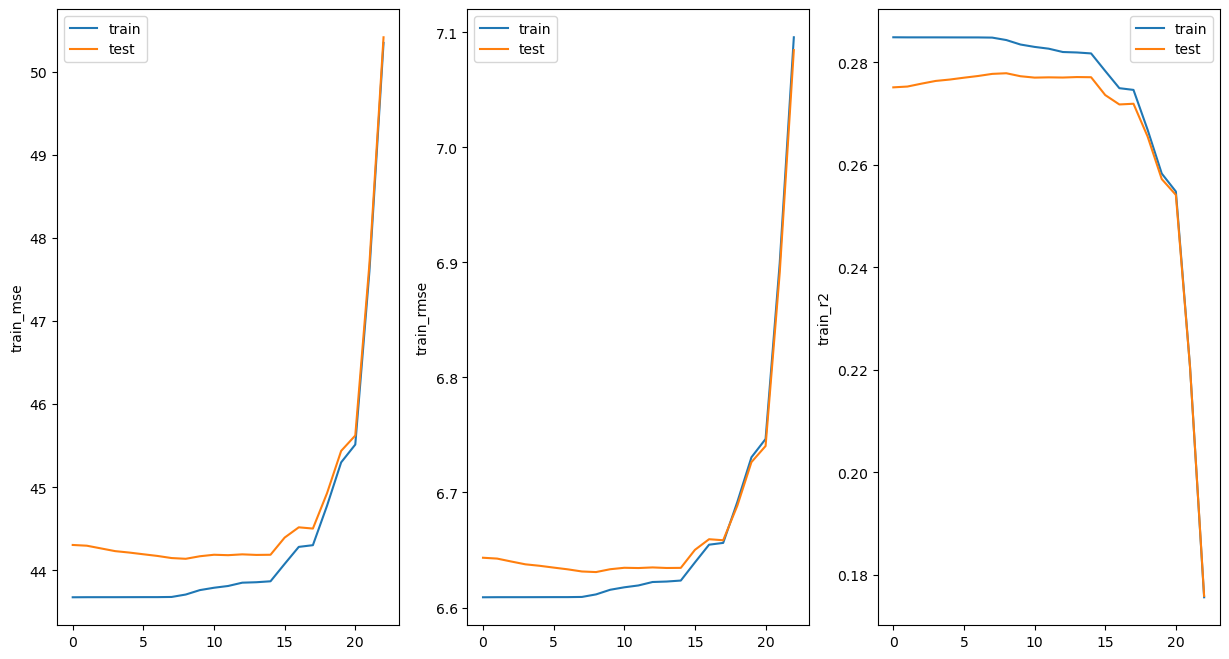

In [518]:
shap_feat_viz_regression(
    best_model_bmi, X_train_transformed_2, y_train, shap_explainer="linear"
)

After testing several numbers of feature reduction, we have found out that reducing the feature space by 8 seem to give the best performance. We will now get the same training set to train on.

In [519]:
cross_val, X_train_reduced = shap_feat_reduce_regression(
    best_model_bmi, X_train_transformed_2, y_train, feats_no=8
)

In [520]:
best_model_bmi.fit(X_train_reduced, y_train)


LinearRegression()

In [521]:
filename = "models/bmi_model.sav"
joblib.dump(best_model_bmi, filename)

['models/bmi_model.sav']

LinearRegression()


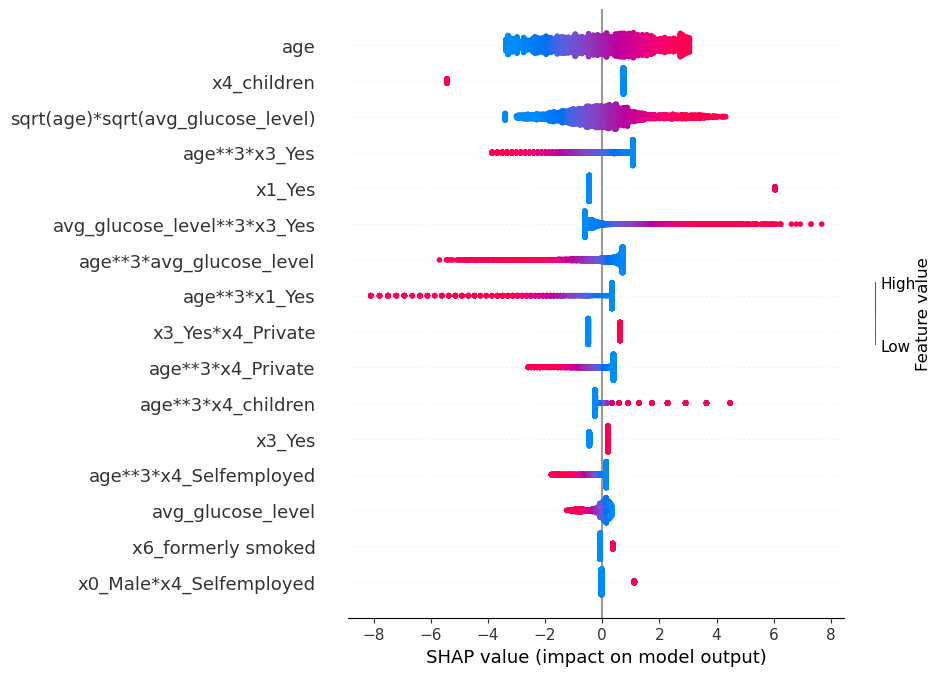

In [522]:
shap_values = shap_viz(best_model_bmi, X_train_reduced, y_train, kind="linear")

As we see from the shap values, age is the most contributing factor to our model predictions. Following features are related to habits, such as being a smoker, being a child etc. This confirms our assumption that bmi is usually related to lifestyle and our feature space is not necessarily helpful to this prediction task.

In [523]:
y_train_pred = best_model_bmi.predict(X_train_reduced)


In [524]:
mean_squared_error(y_true=y_train, y_pred=y_train_pred)


43.71052281378733

In [525]:
mean_squared_error(y_true=y_train, y_pred=y_train_pred, squared=False)


6.611393409394673

The model is making an error of 6.6 bmi, which is a very large value considering expected bmi values.

In [526]:
r2_score(y_true=y_train, y_pred=y_train_pred)


0.2843366690962218

The features are able to explain 28 percent of all variance in the dataset. This means that we need more data to make more accurate predictions.

In [527]:
X_test_transformed = auto_features.transform(X_test)


[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.


In [528]:
X_test_transformed = bmi_final_preprocessor.transform(X_test_transformed)
X_test_transformed = return_col_names(
    X_test_transformed, bmi_final_preprocessor)


In [529]:
final_cols_bmi = X_train_reduced.columns


In [530]:
with open("models/bmi_final_cols", "wb") as bmi_cols:
    pickle.dump(final_cols_bmi, bmi_cols)

In [531]:
X_test_transformed = X_test_transformed[final_cols_bmi]


In [532]:
y_pred = best_model_bmi.predict(X_test_transformed)


In [533]:
mean_squared_error(y_true=y_test, y_pred=y_pred)


47.32899259348827

In [534]:
mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)


6.879607008651604

The error we get from the test set is similar to the error from the training set. However, still this error is too large to be usable in real world setting.

In [535]:
r2_score(y_true=y_test, y_pred=y_pred)


0.2607283612132828

## Hypertension & Glucose Predictor

As required we will fit a model that is able to predict both hypertension and glucose levels. This model still has the same problems mentioned in the individual models. 

In this model, we will have a two model approach instead of a multi-label predictor.

In [589]:
X = stroke.drop(["stroke", "hypertension"], axis=1)
y = stroke["hypertension"]

X_train_hyp, X_test_hyp, y_train_hyp, y_test_hyp = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [590]:
le = LabelEncoder()
y_train_hyp = le.fit_transform(y_train_hyp)
y_test_hyp = le.transform(y_test_hyp)


In [591]:
X = stroke.drop(["stroke", "avg_glucose_level"], axis=1)
y = stroke["avg_glucose_level"]

X_train_glu, X_test_glu, y_train_glu, y_test_glu = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [592]:
X_train_hyp_transformed = transformations.hypertension_data_transform(
    X_train_hyp)


In [593]:
hyp_cols_to_drop = X_train_hyp_transformed.columns[
    X_train_hyp_transformed.columns.str.contains("glucose")
]

In [594]:
X_train_hyp_transformed = X_train_hyp_transformed.drop(
    hyp_cols_to_drop, axis=1)


In [595]:
hyp_glu_dual_cols_1 = X_train_hyp_transformed.columns


In [596]:
with open("models/hyp_glu_dual/cols_1", "wb") as hyp_cols:
    pickle.dump(hyp_glu_dual_cols_1, hyp_cols)

In [597]:
X_train_glu_transformed = transformations.glucose_data_transform(X_train_glu)


[AutoFeat] Computing 6 new features.
[AutoFeat]     6/    6 new features ...done.


In [598]:
glu_cols_to_drop = X_train_glu_transformed.columns[
    X_train_glu_transformed.columns.str.contains("x1_Yes")
]

In [599]:
glu_cols_to_drop


Index(['x1_Yes'], dtype='object')

In [600]:
X_train_glu_transformed = X_train_glu_transformed.drop(
    glu_cols_to_drop, axis=1)


In [601]:
hyp_glu_dual_cols_2 = X_train_glu_transformed.columns


In [602]:
with open("models/hyp_glu_dual/cols_2", "wb") as glu_cols:
    pickle.dump(hyp_glu_dual_cols_2, glu_cols)

In [605]:
with open("hypertension_model.sav", "rb") as hyp_model:
    hypglu_dual_model_1 = joblib.load(hyp_model)

In [606]:
hypglu_dual_model_2 = joblib.load("models/glucose_model.sav")

In [607]:
hypglu_dual_model_1.fit(X_train_hyp_transformed, y_train_hyp)


SVC(C=0.7, class_weight='balanced', degree=1, kernel='poly', probability=True,
    random_state=42)

In [609]:
with open("models/hyp_glu_dual/hyp_model.sav", "wb") as hyp_1:
    joblib.dump(hypglu_dual_model_1, hyp_1)

In [611]:
cv_1 = cross_validate_model(
    [hypglu_dual_model_1],
    X_train_hyp_transformed,
    y_train_hyp,
    task="classification",
    scaler=False,
)

In [612]:
cv_1.style.background_gradient(cmap="Reds")

Dual model is able to detect 80 percent of individuals with hypertension. However, only 20 percent of all these predictions are correct. 

In [613]:
hypglu_dual_model_2.fit(X_train_glu_transformed, y_train_glu)


ElasticNet(alpha=0.3157894736842105, l1_ratio=0.631578947368421, max_iter=500,
           random_state=42)

In [614]:
filename = "models/hyp_glu_dual/glu_model.sav"
joblib.dump(hypglu_dual_model_2, filename)

['models/hyp_glu_dual/glu_model.sav']

In [616]:
cv_2 = cross_validate_model(
    [hypglu_dual_model_2],
    X_train_glu_transformed,
    y_train_glu,
    task="regression",
    scaler=True,
)

In [617]:
cv_2.style.background_gradient(cmap="Reds")

The glucose prediction of this model is off by 43. This is again a very high error considering average glucose levels. 

### Evaluation

In [619]:
X_test_hyp = transformations.hypertension_data_transform(X_test_hyp)
X_test_hyp = X_test_hyp[hyp_glu_dual_cols_1]


In [620]:
y_pred_hyp = hypglu_dual_model_1.predict(X_test_hyp)


In [622]:
print(classification_report(y_test_hyp, y_pred_hyp))


              precision    recall  f1-score   support

           0       0.97      0.65      0.78       922
           1       0.20      0.82      0.33       100

    accuracy                           0.67      1022
   macro avg       0.59      0.74      0.55      1022
weighted avg       0.90      0.67      0.73      1022



The metrics are very similar to what we have seen for the training set. This model is not overfitting. It's able to detect 82 percent of hypertension patients. But the predictions are only true 20 percent of the time.

In [623]:
cm = confusion_matrix(y_test_hyp, y_pred_hyp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_search_2.classes_)

In [625]:
X_test_glu = transformations.glucose_data_transform(X_test_glu)
X_test_glu = X_test_glu[hyp_glu_dual_cols_2]


[AutoFeat] Computing 6 new features.
[AutoFeat]     6/    6 new features ...done.


In [626]:
y_pred_glu = hypglu_dual_model_2.predict(X_test_glu)


In [627]:
mean_squared_error(y_test_glu, y_pred_glu)


1834.2739461644794

In [628]:
mean_squared_error(y_test_glu, y_pred_glu, squared=False)


42.82842451181784

In [629]:
r2_score(y_test_glu, y_pred_glu)


0.08239856881308172

The model is not very good at predicting glucose levels. It is off by 43 on test set. 

## Hypertension & BMI Predictor

In this section, we will create another dual model. As opposed to the previous one, this model replaces glucose levels with BMI and generates Hypertension and BMI predictions.

In [630]:
X = stroke.drop(["stroke", "hypertension"], axis=1)
y = stroke["hypertension"]

X_train_hyp, X_test_hyp, y_train_hyp, y_test_hyp = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [631]:
le = LabelEncoder()
y_train_hyp = le.fit_transform(y_train_hyp)
y_test_hyp = le.transform(y_test_hyp)


In [671]:
bmi = stroke.dropna()
X = bmi.drop(["stroke", "bmi"], axis=1)
y = bmi["bmi"]

X_train_bmi, X_test_bmi, y_train_bmi, y_test_bmi = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [672]:
X_train_hyp_transformed = transformations.hypertension_data_transform(
    X_train_hyp)


In [673]:
X_train_hyp_transformed = X_train_hyp_transformed.drop("bmi", axis=1)

In [674]:
hyp_bmi_dual_cols_1 = X_train_hyp_transformed.columns


In [675]:
with open("models/hyp_bmi_dual/cols_1", "wb") as hyp_cols:
    pickle.dump(hyp_bmi_dual_cols_1, hyp_cols)

In [676]:
X_train_bmi_transformed = transformations.bmi_data_transform(X_train_bmi)


[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.


In [678]:
bmi_cols_to_drop = X_train_bmi_transformed.columns[
    X_train_bmi_transformed.columns.str.contains("x1")
]

In [679]:
X_train_bmi_transformed = X_train_bmi_transformed.drop(
    bmi_cols_to_drop, axis=1)


In [680]:
hyp_bmi_dual_cols_2 = X_train_bmi_transformed.columns


In [681]:
with open("models/hyp_bmi_dual/cols_2", "wb") as bmi_cols:
    pickle.dump(hyp_bmi_dual_cols_2, bmi_cols)

In [682]:
hypbmi_dual_model_1 = joblib.load("hypertension_model.sav")

In [683]:
hypbmi_dual_model_2 = joblib.load("models/bmi_model.sav")

In [684]:
hypbmi_dual_model_1.fit(X_train_hyp_transformed, y_train_hyp)


SVC(C=0.7, class_weight='balanced', degree=1, kernel='poly', probability=True,
    random_state=42)

In [685]:
with open("models/hyp_bmi_dual/hyp_model.sav", "wb") as hyp_m:
    joblib.dump(hypbmi_dual_model_1, hyp_m)

In [686]:
cv_1 = cross_validate_model(
    [hypbmi_dual_model_1],
    X_train_hyp_transformed,
    y_train_hyp,
    task="classification",
    scaler=False,
)

In [687]:
cv_1.style.background_gradient(cmap="Reds")

This model is able to identify 79 percent of all individuals with hypertension. 20 percent of all predictions are correct. 

In [688]:
hypbmi_dual_model_2.fit(X_train_bmi_transformed, y_train_bmi)


LinearRegression()

In [689]:
filename = "models/hyp_bmi_dual/bmi_model.sav"
joblib.dump(hypbmi_dual_model_2, filename)

['models/hyp_bmi_dual/bmi_model.sav']

In [691]:
cv_2 = cross_validate_model(
    [hypbmi_dual_model_2],
    X_train_bmi_transformed,
    y_train_bmi,
    task="regression",
    scaler=True,
)

In [692]:
cv_2.style.background_gradient(cmap="Reds")

BMI performance of this model is very close to the original model we fit. Overall, the performance is not good enough to be useful. 

### Evaluation

In [694]:
X_test_hyp = transformations.hypertension_data_transform(X_test_hyp)
X_test_hyp = X_test_hyp[hyp_bmi_dual_cols_1]


In [695]:
y_pred_hyp = hypbmi_dual_model_1.predict(X_test_hyp)


In [697]:
print(classification_report(y_test_hyp, y_pred_hyp))


              precision    recall  f1-score   support

           0       0.96      0.65      0.78       922
           1       0.19      0.77      0.31       100

    accuracy                           0.67      1022
   macro avg       0.58      0.71      0.54      1022
weighted avg       0.89      0.67      0.73      1022



We see that the test performances are not so different from train set performance. This means that the model is not overfitting. It was able to detect 77 percent of all individuals with hypertension. Only 19 percent of all predictions were correct. 

In [698]:
cm = confusion_matrix(y_test_hyp, y_pred_hyp)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=hypbmi_dual_model_1.classes_
)

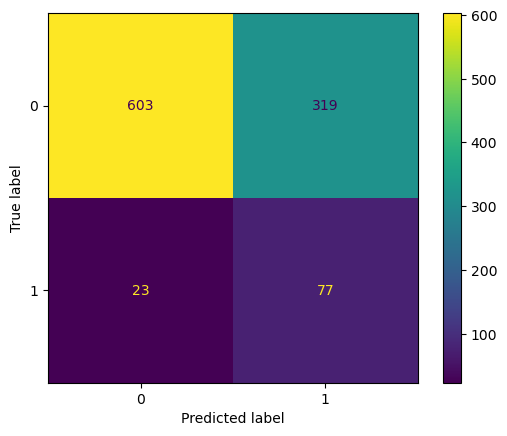

In [699]:
disp.plot()


In the test set, the model was able to correctly identify 77 individuals with hypertension. However, it missed 23 people with hypertension. On the other hand, it assummed wrongly that another 319 people had hypertension issue.

In [701]:
X_test_bmi = transformations.bmi_data_transform(X_test_bmi)
X_test_bmi = X_test_bmi[hyp_bmi_dual_cols_2]


[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.


In [702]:
y_pred_bmi = hypbmi_dual_model_2.predict(X_test_bmi)


In [703]:
mean_squared_error(y_test_bmi, y_pred_bmi)


47.94668157725016

In [704]:
mean_squared_error(y_test_bmi, y_pred_bmi, squared=False)


6.924354235396263

The error this model is making when predicting BMI is too high to be usable. Around 7 BMI values of error would make a very big difference in real life.

In [705]:
r2_score(y_test_bmi, y_pred_bmi)


0.2510801535869708

## Glucose & BMI Predictor

The last dual model is going to predict glucose and BMI levels. As mentioned before, in order to predict these values, more information about an individual's life style is needed. So the models are expected to be underwhelming.

In [846]:
X = stroke.drop(["stroke", "avg_glucose_level"], axis=1)
y = stroke["avg_glucose_level"]

X_train_glu, X_test_glu, y_train_glu, y_test_glu = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [847]:
bmi = stroke.dropna()
X = bmi.drop(["stroke", "bmi"], axis=1)
y = bmi["bmi"]

X_train_bmi, X_test_bmi, y_train_bmi, y_test_bmi = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [848]:
X_train_glu_transformed = transformations.glucose_data_transform(X_train_glu)


[AutoFeat] Computing 6 new features.
[AutoFeat]     6/    6 new features ...done.


In [849]:
X_train_glu_transformed = X_train_glu_transformed.drop(["x1_Severely Obese"], axis=1)

In [850]:
glu_cols_to_drop = X_train_glu_transformed.columns[
    X_train_glu_transformed.columns.str.contains("bmi")
]

In [851]:
X_train_glu_transformed = X_train_glu_transformed.drop(
    glu_cols_to_drop, axis=1)


In [852]:
glu_bmi_dual_cols_1 = X_train_glu_transformed.columns


In [853]:
with open("models/glu_bmi_dual/cols_1", "wb") as glu_cols:
    pickle.dump(glu_bmi_dual_cols_1, glu_cols)

In [854]:
X_train_bmi_transformed = transformations.bmi_data_transform(X_train_bmi)


[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.


In [861]:
X_train_bmi


gender  age hypertension heart_disease ever_married      work_type  \
id                                                                          
68302  Female   40           No            No          Yes        Private   
62716  Female   59           No            No          Yes  Self-employed   
38796  Female   54           No            No          Yes        Private   
4148     Male   81           No            No          Yes  Self-employed   
61672  Female   11           No            No           No       children   
...       ...  ...          ...           ...          ...            ...   
56425  Female   78           No            No          Yes       Govt_job   
27832  Female   51           No            No          Yes        Private   
41182  Female   35          Yes            No          Yes        Private   
68171    Male   61           No            No          Yes  Self-employed   
67864    Male   63           No            No          Yes        Private   

      Residence_type  avg_glucose_level   smoking_status  
id                                                        
68302          Urban              65.77     never smoked  
62716          Urban              81.64          Unknown  
38796          Urban              99.83  formerly smoked  
4148           Urban              71.18  formerly smoked  
61672          Urban              69.68          Unknown  
...              ...                ...              ...  
56425          Rural              61.38          Unknown  
27832          Rural              82.93           smokes  
41182          Urban              94.20           smokes  
68171          Urban             116.78  formerly smoked  
67864          Rural              57.82  formerly smoked  

[3926 rows x 9 columns]

In [855]:
bmi_cols_to_drop = X_train_bmi_transformed.columns[
    X_train_bmi_transformed.columns.str.contains("glucose")
]

In [856]:
X_train_bmi_transformed = X_train_bmi_transformed.drop(
    bmi_cols_to_drop, axis=1)


In [857]:
glu_bmi_dual_cols_2 = X_train_bmi_transformed.columns


In [845]:
with open("models/glu_bmi_dual/cols_2", "wb") as bmi_cols:
    pickle.dump(hyp_glu_dual_cols_2, bmi_cols)

In [729]:
glubmi_dual_model_1 = joblib.load("models/glucose_model.sav")

In [730]:
glubmi_dual_model_1.fit(X_train_glu_transformed, y_train_glu)


ElasticNet(alpha=0.3157894736842105, l1_ratio=0.631578947368421, max_iter=500,
           random_state=42)

In [731]:
filename = "models/glu_bmi_dual/glu_model.sav"
joblib.dump(glubmi_dual_model_1, filename)

['models/glu_bmi_dual/glu_model.sav']

In [733]:
cv_1 = cross_validate_model(
    [glubmi_dual_model_1],
    X_train_glu_transformed,
    y_train_glu,
    task="regression",
    scaler=True,
)

In [734]:
cv_1.style.background_gradient(cmap="Reds")

The double model is also suffering from high error in glucose levels, as the single model. 

In [735]:
glubmi_dual_model_2 = joblib.load("models/bmi_model.sav")

In [736]:
glubmi_dual_model_2.fit(X_train_bmi_transformed, y_train_bmi)


LinearRegression()

In [737]:
filename = "models/glu_bmi_dual/bmi_model.sav"
joblib.dump(glubmi_dual_model_2, filename)

['models/glu_bmi_dual/bmi_model.sav']

In [738]:
cv_2 = cross_validate_model(
    [glubmi_dual_model_2],
    X_train_bmi_transformed,
    y_train_bmi,
    task="regression",
    scaler=True,
)

In [739]:
cv_2.style.background_gradient(cmap="Reds")

As with the previous model, this model makes an error of 6.7 when predicting BMI values.

### Evaluation

In [740]:
X_test_bmi = transformations.bmi_data_transform(X_test_bmi)
X_test_bmi = X_test_bmi[glu_bmi_dual_cols_2]


[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.


In [741]:
y_pred_bmi = glubmi_dual_model_2.predict(X_test_bmi)


In [742]:
mean_squared_error(y_test_bmi, y_pred_bmi)


47.606672549923466

In [743]:
mean_squared_error(y_test_bmi, y_pred_bmi, squared=False)


6.899758876216144

The model makes a similar error to the error it made on the training data.

In [744]:
r2_score(y_test_bmi, y_pred_bmi)


0.2563910426860273

In [746]:
X_test_glu = transformations.glucose_data_transform(X_test_glu)
X_test_glu = X_test_glu[glu_bmi_dual_cols_1]


[AutoFeat] Computing 6 new features.
[AutoFeat]     6/    6 new features ...done.


In [747]:
y_pred_glu = glubmi_dual_model_1.predict(X_test_glu)


In [748]:
mean_squared_error(y_test_glu, y_pred_glu)


1879.2684140505994

In [749]:
mean_squared_error(y_test_glu, y_pred_glu, squared=False)


43.35052957059002

This is again similar to the error we have seen on the validation data. However, the error is again too high to be usable.

In [750]:
r2_score(y_test_glu, y_pred_glu)


0.05988994178159068

## Hypertension, Glucose & BMI Predictor

Our last model will be a combination of hypertension, glucose and BMI levels predictions.

In [751]:
X = stroke.drop(["stroke", "avg_glucose_level"], axis=1)
y = stroke["avg_glucose_level"]

X_train_glu, X_test_glu, y_train_glu, y_test_glu = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [752]:
bmi = stroke.dropna()
X = bmi.drop(["stroke", "bmi"], axis=1)
y = bmi["bmi"]

X_train_bmi, X_test_bmi, y_train_bmi, y_test_bmi = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [753]:
X = stroke.drop(["stroke", "hypertension"], axis=1)
y = stroke["hypertension"]

X_train_hyp, X_test_hyp, y_train_hyp, y_test_hyp = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [803]:
le = LabelEncoder()
y_train_hyp = le.fit_transform(y_train_hyp)
y_test_hyp = le.transform(y_test_hyp)


In [754]:
X_train_glu_transformed = transformations.glucose_data_transform(X_train_glu)


[AutoFeat] Computing 6 new features.
[AutoFeat]     6/    6 new features ...done.


In [765]:
hyp_cols_to_drop = X_train_glu_transformed.columns[
    X_train_glu_transformed.columns.str.contains("x1")
    | X_train_glu_transformed.columns.str.contains("bmi")
]

In [768]:
X_train_glu_transformed = X_train_glu_transformed.drop(
    hyp_cols_to_drop, axis=1)


In [777]:
glu_bmi_hyp_cols_1 = X_train_glu_transformed.columns


In [778]:
with open("models/glu_bmi_hyp/cols_1", "wb") as glu_cols:
    pickle.dump(glu_bmi_hyp_cols_1, glu_cols)

In [779]:
X_train_hyp_transformed = transformations.hypertension_data_transform(
    X_train_hyp)


In [780]:
hyp_cols_to_drop = X_train_hyp_transformed.columns[
    X_train_hyp_transformed.columns.str.contains("glucose")
    | X_train_hyp_transformed.columns.str.contains("bmi|x1")
]

In [782]:
X_train_hyp_transformed = X_train_hyp_transformed.drop(
    hyp_cols_to_drop, axis=1)


In [783]:
glu_bmi_hyp_cols_2 = X_train_hyp_transformed.columns


In [784]:
with open("models/glu_bmi_hyp/cols_2", "wb") as hyp_cols:
    pickle.dump(glu_bmi_hyp_cols_2, hyp_cols)

In [785]:
X_train_bmi_transformed = transformations.bmi_data_transform(X_train_bmi)


[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.


In [786]:
bmi_cols_to_drop = X_train_bmi_transformed.columns[
    X_train_bmi_transformed.columns.str.contains("glucose")
    | X_train_bmi_transformed.columns.str.contains("bmi|x1")
]

In [790]:
X_train_bmi_transformed = X_train_bmi_transformed.drop(
    bmi_cols_to_drop, axis=1)


In [791]:
glu_bmi_hyp_cols_3 = X_train_bmi_transformed.columns


In [792]:
with open("models/glu_bmi_hyp/cols_3", "wb") as bmi_cols:
    pickle.dump(glu_bmi_hyp_cols_3, bmi_cols)

In [794]:
glu_bmi_hyp_model_1 = joblib.load("models/glucose_model.sav")

In [796]:
glu_bmi_hyp_model_2 = joblib.load(
    "/Users/fet/Projects.nosync/Stroke Prediction/hypertension_model.sav"
)

In [797]:
glu_bmi_hyp_model_3 = joblib.load("models/bmi_model.sav")

In [804]:
glu_bmi_hyp_model_2.fit(X_train_hyp_transformed, y_train_hyp)


SVC(C=0.7, class_weight='balanced', degree=1, kernel='poly', probability=True,
    random_state=42)

In [805]:
filename = "models/glu_bmi_hyp/hyp_model.sav"
joblib.dump(glu_bmi_hyp_model_2, filename)

['models/glu_bmi_hyp/hyp_model.sav']

In [806]:
cv_1 = cross_validate_model(
    [glu_bmi_hyp_model_2],
    X_train_hyp_transformed,
    y_train_hyp,
    task="classification",
    scaler=False,
)

In [807]:
cv_1.style.background_gradient(cmap="Reds")

In [808]:
glu_bmi_hyp_model_1.fit(X_train_glu_transformed, y_train_glu)


ElasticNet(alpha=0.3157894736842105, l1_ratio=0.631578947368421, max_iter=500,
           random_state=42)

In [809]:
filename = "models/glu_bmi_hyp/glu_model.sav"
joblib.dump(glu_bmi_hyp_model_1, filename)

['models/glu_bmi_hyp/glu_model.sav']

In [812]:
cv_2 = cross_validate_model(
    [glu_bmi_hyp_model_1],
    X_train_glu_transformed,
    y_train_glu,
    task="regression",
    scaler=True,
)

In [813]:
cv_2.style.background_gradient(cmap="Reds")

In [814]:
glu_bmi_hyp_model_3.fit(X_train_bmi_transformed, y_train_bmi)


LinearRegression()

In [815]:
filename = "models/glu_bmi_hyp/bmi_model.sav"
joblib.dump(glu_bmi_hyp_model_3, filename)

['models/glu_bmi_hyp/bmi_model.sav']

In [816]:
cv_3 = cross_validate_model(
    [glu_bmi_hyp_model_3],
    X_train_bmi_transformed,
    y_train_bmi,
    task="regression",
    scaler=True,
)

In [817]:
cv_3.style.background_gradient(cmap="Reds")

### Evaluation

In [818]:
X_test_hyp = transformations.hypertension_data_transform(X_test_hyp)
X_test_hyp = X_test_hyp[glu_bmi_hyp_cols_2]


In [819]:
y_pred_hyp = glu_bmi_hyp_model_2.predict(X_test_hyp)


In [821]:
print(classification_report(y_test_hyp, y_pred_hyp))


              precision    recall  f1-score   support

           0       0.96      0.62      0.75       922
           1       0.18      0.79      0.30       100

    accuracy                           0.63      1022
   macro avg       0.57      0.70      0.52      1022
weighted avg       0.89      0.63      0.71      1022



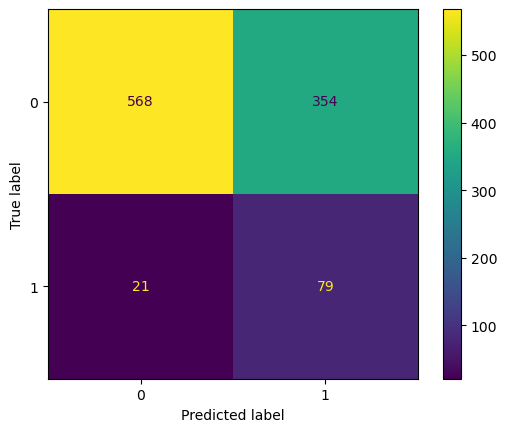

In [822]:
cm = confusion_matrix(y_test_hyp, y_pred_hyp)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=glu_bmi_hyp_model_2.classes_
)
disp.plot()

In [823]:
X_test_bmi = transformations.bmi_data_transform(X_test_bmi)
X_test_bmi = X_test_bmi[glu_bmi_hyp_cols_3]


[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.


In [824]:
y_pred_bmi = glu_bmi_hyp_model_3.predict(X_test_bmi)


In [825]:
mean_squared_error(y_test_bmi, y_pred_bmi)


48.42419562175487

In [826]:
mean_squared_error(y_test_bmi, y_pred_bmi, squared=False)


6.958749573145657

In [827]:
r2_score(y_test_bmi, y_pred_bmi)


0.24362145711192196

In [828]:
X_test_glu = transformations.glucose_data_transform(X_test_glu)
X_test_glu = X_test_glu[glu_bmi_hyp_cols_1]


[AutoFeat] Computing 6 new features.
[AutoFeat]     6/    6 new features ...done.


In [829]:
y_pred_glu = glu_bmi_hyp_model_1.predict(X_test_glu)


In [830]:
mean_squared_error(y_test_glu, y_pred_glu)


1881.8153883050836

In [831]:
mean_squared_error(y_test_glu, y_pred_glu, squared=False)


43.37989613063964

In [832]:
r2_score(y_test_glu, y_pred_glu)


0.05861580973277769

In all predictions, the models produced very similar results to the single models we have created. However, with large errors glucose and bmi predictors do not seem to be usable. Hypertension model on the other hand, is able to identify most people with hypertension. The problem with this model is that it has a low precision, which means that most of its predictions are incorrect.

## Summary

In this project, we have worked towards building machine learning models to automate the diagnosing for several health issues, and predicting other health related values. At first we have built several models that are able to predict only one target. These targets were stroke, hypertension, average glucose level, and bmi. 

The first model was built with an aim to automatically detect patients with a stroke risk. Such a system could automatically alert doctors to take swift precautions and help the patients. After trying several methods, we ended up with a model which was able to correctly identify most of the patients with a stroke risk. However, the predictions of this model was not necessarily accurate. Most of the predictions made by this model was not actually correct. But, as we stated at the beginning, the aim of this model was to identify as many people as possible with a stroke risk, so that nobody goes unreported. Unfortunately, as a side effect this model has a high chance of making a false call. This situation is preferable to the opposite case, where patients with a stroke risk go undetected. 

The second model is a hypertension risk prediction model. This model shares characteristics with the first model in several aspects. Firstly, we had a similar approach with this model, in which we aimed to identify as many people as possible with a hypertension risk. As before, we ignored that the model was labelling some patients incorrectly. Overall, the model performance was close to the first model.

The main idea behind the next model was to easily detect glucose levels of a patient without taking blood tests. However, predicting glucose levels may require us to feed some data about different levels in blood. What we had instead is about other health conditions and some lifestyle information of patients. As we assumed, this model did not work very well. The error made by the model was not reasonable and this made the model unfit to be used in real life scenario. 

Last model also suffers from the same problems as the previous model. This model was built in purpose of predicting a patient's BMI without measuring their height and weight. However, this kind of prediction may require more data about the patient's life style. This dataset was not necessarily very informative in that area, and the model was unable to catch the characteristics of BMI. The error the model is making makes it unusable in professional setting.

The following models were the combination of other models. None of the model did suffer from any problem we have not seen on the single models. All models largely shared the same patterns with the original ones.  

## Next Steps

As mentioned in previous stages, some models lacked relevant data to perform their duties optimally. In order to fix this problems, we need to collect more relevant data and retrain most of the models.

As the first two models were not very accurate in their predictions, they should not be used by individuals, as this may lead to unnecessary alert for themselves and their close ones. Instead, these models should be used by health professionals, who are able to detect when the model is making a false alarm.

Another problem with the project is that we needed to build models that were supposed to predict multilabels. As the data is already limited, this approach is not a very productive way to getting the models work. We needed to effectively eliminate extra columns in order to make this model work. However, the models were working better when they were fed more information.